## Heart Attack Prediction Model 
## Preproceessing - Feature Engineering, Data Preparation
## Modeling - Baseline Modeling, Baseline Model Evaluations 

---

## Introduction
This notebook is composed of five main sections:
1. Defining Metrics of Success:  Before delving into baseline modeling, I will first establish the metrics of success from both business and technical perspectives. This will ensure that I focus on the relevant metrics when evaluating machine learning models.
2. Feature Engineering:  I will leverage insights gained from the exploratory data analysis (EDA) to create features suitable for machine learning. At this stage, I will not perform feature selection; I will reserve that for after baseline modeling, using feature importance findings from various models.
3. Data preparation: In this section, I will execute one-hot encoding, apply resampling techniques to address class imbalance, implement feature scaling, and conduct dimensionality reduction using Principal Component Analysis (PCA). Additionally, I will create functions for model evaluation.
4. Baseline Modeling: I will train several models, including Logistic Regression, Naive Bayes, Decision Tree, Random Forest, XGBoost, and Neural Networks, on imbalanced, upsampled, and downsampled training datasets. Following this, I will identify the best model from each category and compare their performance metrics.
5. Advanced Feature Selection and additional modeling: After training and evaluating the baseline models, I will perform feature selection to refine the dataset to the most impactful features, considering both model performance and business relevance. I will then retrain the models and compare their performance before and after feature selection.

---


## Author: Will Wu

## Date: 2025-03-14
---

## **Table of Contents** ##
1. [Defining Metrics of Success](#1)
2. [Setup and Load Data](#2)
3. [Initial Feature Engineering](#3)
    - [Binning Data - `bmi`](#3a)
    - [Feature Selection](#3b)
4.  [Data Preparation](#4)
    - [Binary Encoding](#4a)
    - [Train-Test-Split](#4b)
    - [Log Transformation of Non-Normal Features](#4c)
    - [One-Hot Encoding](#4d)
    - [Feature Scaling](#4e)
    - [Handling Class Imbalance](#4f)
    - [Reducing Dimensionality using PCA](#4g)
    - [Additional preparations](#4h)
     
5. [Baseline Modeling - Logistic Regression](#5)
    - [Logistic Regression With Imbalanced Class](#5a)
    - [Logistic Regression With Upsampling](#5b)
    - [Logistic Regression With Downsampling](#5c)
    - [Logistic Regression With Oversampling](#5d)
    - [Best Model with PCA](#5e)
    - [Logistic Regression Baseline Modeling Summary](#5f)

6. [Baseline Modeling - Naive Bayes](#6)
    - [Naive Bayes With Imbalanced Class](#6a)
    - [Naive Bayes With Upsampling](#6b)
    - [Naive Bayes With Downsampling](#6c)
    - [Naive Bayes Baseline Modeling Summary](#6d)

7. [Baseline Modeling - Decision Tree](#7)
    - [Decision Tree With Imbalanced Class](#7a)
    - [Decision Tree With Upsampling](#7b)
    - [Decision Tree With Downsampling](#7c)
    - [Decision Tree Baseline Modeling Summary](#7d)

8. [Baseline Modeling - Random Forest](#8)
    - [Random Forest With Imbalanced Class](#8a)
    - [Random Forest With Upsampling](#8b)
    - [Random Forest With Downsampling](#8c)
    - [Random Forest Baseline Modeling Summary](#8d)

9. [Baseline Modeling - XGBoost](#9)
    - [XGBoost With Imbalanced Class](#9a)
    - [XGBoost With Upsampling](#9b)
    - [XGBoost With Downsampling](#9c)
    - [Best Model with PCA](#9d)
    - [XGBoost Baseline Modeling Summary](#9e)

10. [Baseline Modeling - Neural Network](#10)
    - [Neural Network With Downsampled Data](#10a)
    - [Neural Network Baseline Modeling Summary](#10b)


11. [Baseline Model Evaluation](#11)
    - [Important/Predictive Features in Various Baseline Models](#11a)
    - [Model Comparison and Summary](#11b)
    - [In-Depth Analysis of Top Performing Baseline Models](#11b)

12. [Advanced Feature Engineering](#12)
    - [Feature Selection](#12a)
    - [Retrain Baseline Model](#12b)
    - [Comparison and Summary](#12c)
13. [Export Model and Data](#13)



---

## 1. Defining Metrics of Success<a class="anchor" id="1"></a>

- The primary purpose of this notebook is to establish baseline models, which will involve feature engineering, data preparation, training various models, and model evaluations. Before diving into these steps, I will first define the metrics of success to help set the tone and direction of the modeling process.
- Given the highly imbalanced distribution of the target variable (94.7% negative vs. 5.3% positive), **accuracy is not a suitable metric**. A simple classifier that predicts all targets as negative would achieve an impressive accuracy of 94.7%, yet it would fail to identify any positive cases. Therefore, alternative metrics that better capture the model's performance on the minority class should be considered.
- Considering that the goal of this project is to create an early detection system for identifying the risk of a heart attack, the **primary objective** of the modeling is to achieve a **high recall score**. Recall measures the model's ability to correctly identify true positive cases, which is crucial for timely intervention.
- A **low false positive rate** is also important, and should be considered as the **secondary goal**. An excessively high recall can lead to many false positives, where low-risk individuals are incorrectly flagged as high-risk. This results in unnecessary medical consultations and interventions, causing undue stress and resource waste for those not at risk, ultimately compromising the model's reliability.
- Research shows that 80-90% of myocardial infarctions (MIs) are linked to modifiable risk factors, leaving 10-20% unexplained. The study[Effect of potentially modifiable risk factors associated with myocardial infarction in 52 countries (the INTERHEART study): case-control study](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(04)17018-9/fulltext) identified common modifiable factors—such as smoking, hypertension, and diabetes—that account for approximately 90% of global MIs, while the remaining cases can be attributed to genetics or unmeasured variables like psychosocial stress. 
- Therefore, **the model should prioritize a recall of 0.8-0.9 for early detection, balancing it with a manageable false positive rate to maintain efficiency and trust in its predictions.**
- 
---

## 2. Setup and Loading<a class="anchor" id="2"></a>

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,  roc_auc_score
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import pickle



In [891]:
# Setting figure size, fontsize globally in the notebook
plt.rcParams["figure.figsize"] = (6, 6)

# Set default grid
sns.set_style('darkgrid')

In [892]:
# Load the dataset
df = pd.read_csv("../data/processed/heart_attack_clean_final.csv")
df.shape

(751985, 37)

In [893]:
# Check top 5 rows
df.head()

,year,sex,race_ethnicity_category,age_category,state,height,weight,bmi,alcohol_drinkers,general_health,...,difficulty_walking,difficulty_concentrating,difficulty_dressing_bathing,difficulty_errands,last_checkup_time,chest_scan,flu_vax,tetanus_vax,pneumo_vax,had_heart_attack
0,2022,Female,White,80+,Alabama,1.60,78.02,30.48,No,Very good,...,Yes,No,No,No,Past 1-2 years,not_asked,No,not_asked,No,No
1,2022,Female,White,80+,Alabama,1.45,59.87,28.48,No,Very good,...,No,No,No,No,Past 1-2 years,not_asked,Yes,not_asked,Yes,No
2,2022,Female,Black,80+,Alabama,1.63,58.97,22.20,No,Fair,...,Yes,Yes,No,No,Past year,not_asked,Yes,not_asked,Yes,No
3,2022,Female,White,75-79,Alabama,1.68,77.11,27.32,No,Very good,...,Yes,No,No,No,Past 2-5 years,not_asked,Yes,not_asked,Yes,No
4,2022,Female,White,75-79,Alabama,1.73,77.11,25.76,Yes,Fair,...,Yes,Yes,No,Yes,Past year,not_asked,No,not_asked,Yes,No


---

## 3. Initial Feature Engineering <a class="anchor" id="3"></a>

In [894]:
# Create a feature engineer df
df_engineer = df.copy()

### 3.1 Binning Data - `bmi`  <a class="anchor" id="3a"></a>

- From preliminary EDA, the distribution of `bmi` is slightly right-skewed, with notable outliers at the higher end. Therefore, converting bmi into bins could be beneficial in mitigating the impact of these outliers.
- According to the BMI definition, individuals are categorized as 'underweight' (bmi < 18.5), 'healthy' (18.5 <= bmi < 25), 'overweight' (25 <= bmi < 30), or 'obese' (bmi > 30). Preliminary EDA findings indicate that the boundary between 'healthy' and 'obese' (BMI of 25) is a critical point, with those below this threshold less likely to experience a heart attack. Thus, I aim to bin the numeric BMI values into categories to explore how the likelihood of having a heart attack varies. To approach this, I will:
    - Create a subset that stores `bmi`, target varaible `had_heart_attack`, and create a bmi_category column
    - Calculate the possibility of having a heart attack for each bmi_category
    - Visulize the possibility to see if there is any difference.

In [ ]:
# Create a function that turns bmi into bins
def get_bmi_bin(bmi):
    """
    Return the BMI category based on the input bmi value.

    If bmi <= 0, raise ValueError.

    Args:
        bmi (float): Numeric BMI value.

    Returns:
        str: One of the following categories: 'underweight', 'healthy', 'overweight', 'obese'.

    """
    if bmi <= 0:
        raise ValueError('BMI cannot be less or equal to Zero.')

    match bmi:
        case _ if bmi < 18.5:
            return 'underweight'
        case _ if bmi < 25:
            return 'healthy'
        case _ if bmi < 30:
            return 'overweight'
        case _:
            return 'obese'

In [896]:
# Create a new subset with bmi and had_heart_attack
bmi_df = df_engineer[['bmi', 'had_heart_attack']].copy()

# Create a new column that maps bmi into category
bmi_df['bmi_category'] = bmi_df['bmi'].apply(get_bmi_bin)
bmi_df.head()

,bmi,had_heart_attack,bmi_category
0,30.48,No,obese
1,28.48,No,overweight
2,22.20,No,healthy
3,27.32,No,overweight
4,25.76,No,overweight


In [897]:
# Find the percentage of people who had heart_attack within each bmi_category
bmi_likelihood_df = (bmi_df.groupby('bmi_category')['had_heart_attack']\
                     .value_counts(normalize=True)*100).unstack()

bmi_likelihood_df

had_heart_attack,No,Yes
bmi_category,,
healthy,95.750308,4.249692
obese,93.860508,6.139492
overweight,94.667780,5.332220
underweight,94.787380,5.212620


In [898]:
# Calculate the Overall probability of having a heart attack
p_heart_attack = (bmi_df['had_heart_attack'].value_counts(normalize=True) * 100)
p_heart_attack = p_heart_attack['Yes']
print(f"The overall probability of having a heart attack {p_heart_attack:.2f}%")

The overall probability of having a heart attack 5.28%


C:\Users\yehua\AppData\Local\Temp\ipykernel_20588\2884972243.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bmi_category',


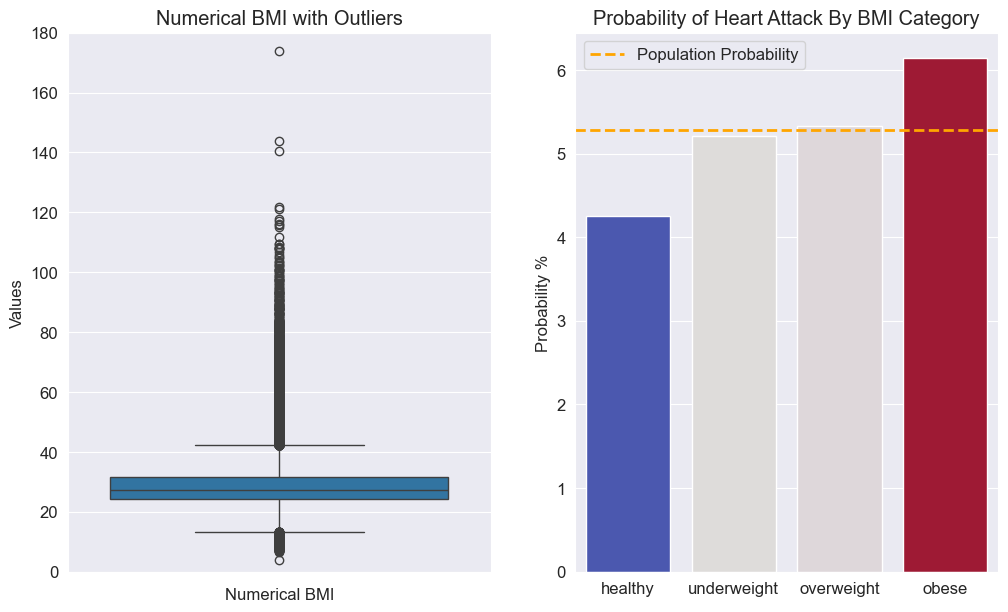

In [ ]:
# Plot the likelihood of having a heart attack by bmi_category
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

sns.boxplot(df['bmi'], ax=axes[0])
axes[0].set_title('Numerical BMI with Outliers')
axes[0].set_ylabel('Values')
axes[0].set_xlabel('Numerical BMI')
axes[0].set_ylim(0, 180)

# Create a bmi_colors for plotting
bmi_colors = [(0.2298057, 0.298717966, 0.753683153, 1.0),
  (0.8755573874313726, 0.860242158862745, 0.8514300660980393, 1.0),
 (0.8755573874313726, 0.840242158862745, 0.8514300660980393, 1.0),
 (0.705673158, 0.01555616, 0.150232812, 1.0)]

# Plot the likelihood of having a heart attack by each bmi_category
sns.barplot(x='bmi_category', 
            y='Yes', 
            data=bmi_likelihood_df.sort_values(by='Yes'), 
            palette=bmi_colors, 
            ax=axes[1] 
            )

# Plot the horizontal line of overall probability of having a heart attack
axes[1] .axhline(y=p_heart_attack, 
            ls='--', 
            lw=2, 
            color='orange', 
            label='Population Probability'
            )

axes[1].set_title('Probability of Heart Attack By BMI Category')
axes[1].set_xlabel('')
axes[1].set_ylabel('Probability %')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend()

plt.show()

**Takeaways**:
- The likelihood of having a heart attack differs across various BMI categories. The 'healthy' group shows a notably lower likelihood of experiencing a heart attack, while the 'obese' group exhibits a higher likelihood.
- The boxplot indicate there are outliers of BMI, and binning numerical values into categories can help mitigate the impact of outliers.
- Consequently, I will add a new feature, `bmi_category` to to categorize the `bmi` values.

In [900]:
# Create bmi_category column
bmi_category = df_engineer['bmi'].apply(get_bmi_bin)

# Insert the column into 8th position
df_engineer.insert(loc=8, column='bmi_category', value=bmi_category)

In [901]:
# Sanity Check
df_engineer['age_category'].isna().sum()

0

In [902]:
# Check the head of df
df_engineer.head().T

,0,1,2,3,4
year,2022,2022,2022,2022,2022
sex,Female,Female,Female,Female,Female
race_ethnicity_category,White,White,Black,White,White
age_category,80+,80+,80+,75-79,75-79
state,Alabama,Alabama,Alabama,Alabama,Alabama
height,1.6,1.45,1.63,1.68,1.73
weight,78.02,59.87,58.97,77.11,77.11
bmi,30.48,28.48,22.2,27.32,25.76
bmi_category,obese,overweight,healthy,overweight,overweight
alcohol_drinkers,No,No,No,No,Yes


---

### 3.2 Feature Selection <a class="anchor" id="3b"></a>


I will proceed to run various models using the full dataset without conducting feature selection at this stage. After evaluating the performance metrics, I will determine if feature selection or additional feature engineering are necessary.

---

## 4. Data Preparation  <a class="anchor" id="4"></a>

### 4.1 Binary Encoding <a class="anchor" id="4a"></a>

Transform binary columns into 1 and 0.

In [903]:
# Create a copy of df
df_encoded = df_engineer.copy()

Fetch binary columns, and print unique values within each binary column.

In [904]:
# Create an empty list
binary_cols = []

# Iterate each column, find the one that are both binary and categorical
for col in df_encoded.columns:
    if (df_encoded[col].nunique() == 2) & (df_encoded[col].dtype == 'object'):
        print(f'Column Name: {col}')
        print(f'Unique Values: {df[col].unique()}')
        print('----' * 8)

        # Append to the list
        binary_cols.append(col)



Column Name: sex
Unique Values: ['Female' 'Male']
--------------------------------
Column Name: physical_activities
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_angina
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_stroke
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_asthma
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_heart_attack
Unique Values: ['No' 'Yes']
--------------------------------


Most of the columns are 'Yes' and 'No' column, I will create dictionaries for mapping these columns into 1 and 0. Before encoding, I will first check the top for rows in df_encoded DataFrame.

In [905]:
# Check the head of df_encoded
df_encoded[binary_cols].head()

,sex,physical_activities,had_angina,had_stroke,had_asthma,had_heart_attack
0,Female,No,No,No,No,No
1,Female,Yes,No,No,No,No
2,Female,Yes,No,No,Yes,No
3,Female,Yes,No,No,No,No
4,Female,Yes,No,No,No,No


In [906]:
# Create dictionaries for mapping
yes_no = {
    'Yes' : 1,
    'No' : 0
}

is_female = {
    'Female' : 1,
    'Male' : 0
}

In [907]:
# Turn binary columns into binary values
for col in binary_cols:

    if col == 'sex': 
        df_encoded[col] = df_encoded[col].map(is_female)  # If the column is sex, use is_female for map
    else:
        df_encoded[col] = df_encoded[col].map(yes_no)   # Use yes_no for mapping other binary columns

In [908]:
# Sanity check
df_encoded[binary_cols].head()

,sex,physical_activities,had_angina,had_stroke,had_asthma,had_heart_attack
0,1,0,0,0,0,0
1,1,1,0,0,0,0
2,1,1,0,0,1,0
3,1,1,0,0,0,0
4,1,1,0,0,0,0


The binary encoding is successfully executed, I will rename `sex` to `is_female` for interpretation purpose. 

In [909]:
# Rename sex column
df_encoded = df_encoded.rename(columns={'sex' : 'is_female'})

In [910]:
# Sanity check
df_encoded.head(2)

,year,is_female,race_ethnicity_category,age_category,state,height,weight,bmi,bmi_category,alcohol_drinkers,...,difficulty_walking,difficulty_concentrating,difficulty_dressing_bathing,difficulty_errands,last_checkup_time,chest_scan,flu_vax,tetanus_vax,pneumo_vax,had_heart_attack
0,2022,1,White,80+,Alabama,1.60,78.02,30.48,obese,No,...,Yes,No,No,No,Past 1-2 years,not_asked,No,not_asked,No,0
1,2022,1,White,80+,Alabama,1.45,59.87,28.48,overweight,No,...,No,No,No,No,Past 1-2 years,not_asked,Yes,not_asked,Yes,0


Since the dataset with binary encoding is essentially the same as the one before encoded, I will update df_engineer to binary encoded.

In [911]:
# Update df_engineeri to have binary encoded
df_engineer = df_encoded.copy()

---

### 4.2 Train-Test-Split   <a class="anchor" id="4b"></a>

In [912]:
# Load the data and split into X and y
X = df_encoded.loc[:, df_encoded.columns != 'had_heart_attack']
y = df_encoded['had_heart_attack']

In [913]:
# Check shape
print(f'Shape of X is {X.shape}')
print(f'Shape of y is {y.shape}')

Shape of X is (751985, 37)
Shape of y is (751985,)


In [914]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=1)

In [915]:
# Print the size and target varaible distribution
print(f'X_train shape: {X_train.shape}')
print(f'Percentage of rows had heart attack (train set) {(y_train.mean()):.2%}')

print(f'X_test shape: {X_test.shape}')
print(f'Percentage of rows had heart attack (test set) {(y_test.mean()):.2%}')

X_train shape: (563988, 37)
Percentage of rows had heart attack (train set) 5.28%
X_test shape: (187997, 37)
Percentage of rows had heart attack (test set) 5.28%


**Overview of Train, Validation, and Test set**:

| Dataset     | Rows | Cols (X + y)| Percentage of Had Heart Attack|
|-------------|------|------|---------------------------------|
| Train       | 563,988| 37 + 1   | 5.28%                             |
| Test        | 187,997 | 37 + 1  | 5.28%                             |

---

### 4.3 Log Transformation of Non-Normal Features <a class="anchor" id="4c"></a>

Based on the findings on preliminary EDA, I found that both `physical_health_days` and `mental_heanlth_days` have extremely right-skewed, non-normal distribution. In this section 

In [916]:
# Create a list of unnormal features
nonnormal_columns = ['physical_health_days', 'mental_health_days']

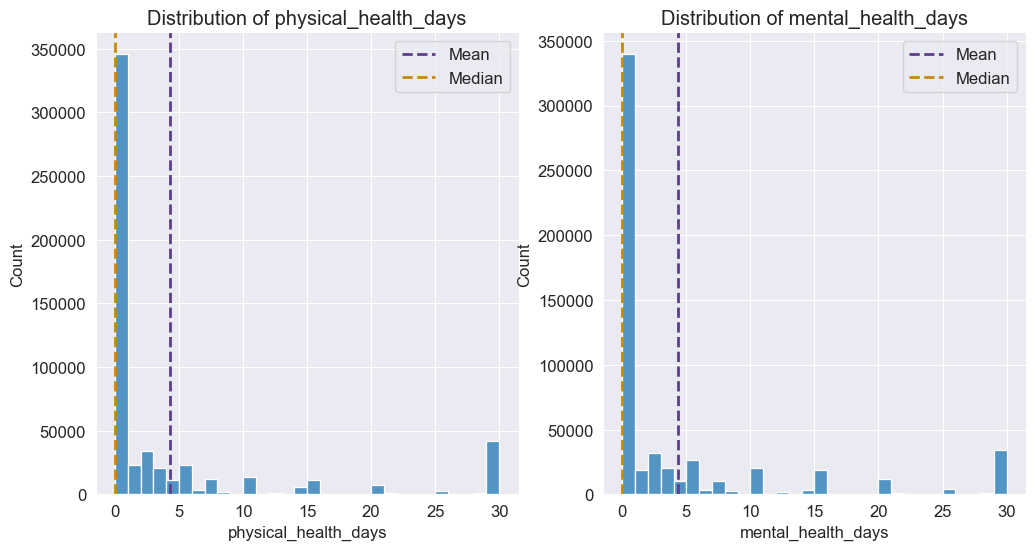

In [917]:
# Recap of physical_health_days and mental_health_days distributions
fig, axes = plt.subplots(1, 2, figsize=(12,6))

for idx, col in enumerate(nonnormal_columns):
    
    # Create the histogram
    sns.histplot(X_train[col], bins=30, ax=axes[idx])
    axes[idx].axvline(x=X_train[col].mean(), color='#5B3E8E', ls='--', lw=2, label='Mean')
    axes[idx].axvline(x=X_train[col].median(), color='#C6890B', ls='--', lw=2, label='Median')
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_ylabel(f'Count')
    axes[idx].legend()

plt.show()

In [918]:
# Instantiate Transformer
log_transformer = FunctionTransformer(func=np.log1p)

# Fit and Transform the training data
X_train[nonnormal_columns] = log_transformer.fit_transform(X_train[nonnormal_columns])

# Transform The X_test
X_test[nonnormal_columns] = log_transformer.transform(X_test[nonnormal_columns])

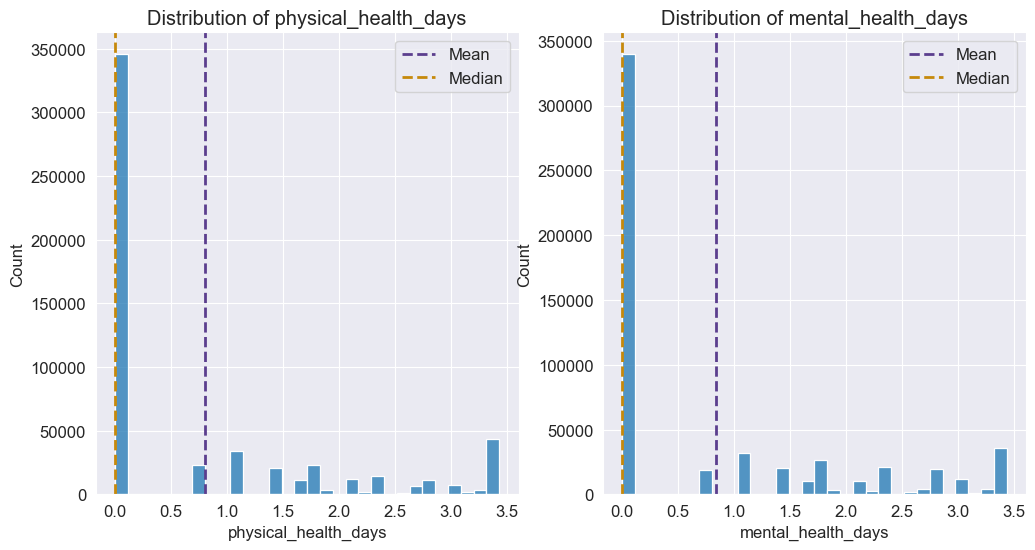

In [919]:
# Recap of physical_health_days and mental_health_days distributions
fig, axes = plt.subplots(1, 2, figsize=(12,6))

for idx, col in enumerate(nonnormal_columns):
    
    # Create the histogram
    sns.histplot(X_train[col], bins=30, ax=axes[idx])
    axes[idx].axvline(x=X_train[col].mean(), color='#5B3E8E', ls='--', lw=2, label='Mean')
    axes[idx].axvline(x=X_train[col].median(), color='#C6890B', ls='--', lw=2, label='Median')
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_ylabel(f'Count')
    axes[idx].legend()

plt.show()


Even though the distributions of `physical_health_days` and `mental_health_days` remain right-skewed after the log transformation, the data points are now more densely clustered together.

---

### 4.4 One-Hot Encoding <a class="anchor" id="4d"></a>

In [920]:
# Get the categorical and numeric columns
original_categorical_columns = X_train.select_dtypes(include='object').columns.tolist()
numeric_columns = X_train.select_dtypes(include='number').columns.tolist()


In [921]:
# Calculate the sum of unique categories for all categorical columns
# Create a variable to store the cum sum and set zero
cumsum_categories = 0

for col in original_categorical_columns:
    cumsum_categories += X_train[col].nunique()

print(f'Total number of categorical columns: {len(original_categorical_columns)}. ')
print(f'Total number of unique categories within each categorical column: {cumsum_categories}. ')

Total number of categorical columns: 26. 
Total number of unique categories within each categorical column: 164. 


In [922]:
# Instantiate the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit transform the X_train categorical variables to array
encoded_array_train = encoder.fit_transform(X_train[original_categorical_columns])

# Convert from arrary to DataFrame
encoded_df_train = pd.DataFrame(
    encoded_array_train, 
    columns=encoder.get_feature_names_out(original_categorical_columns),
    index=X_train.index)

# Concatenate with encoded df
X_train_encoded = pd.concat([X_train[numeric_columns], encoded_df_train], axis=1)


In [923]:
# Sanity check
# Check if number of rows are consistent before and after one-hot-encoding
same_rows = (X_train.shape[0] == X_train_encoded.shape[0])

# Number of expected columns: Number of numeric columns + Number of dummy columns (after dropping one column per categorical column)
same_cols = ((cumsum_categories + len(numeric_columns)) == X_train_encoded.shape[1])

# Print sanity check results
print(f'If X_train and X_train_encoded has same rows: {same_rows}')
print(f'If X_train_encoded has expected number of columns {same_cols}')

If X_train and X_train_encoded has same rows: True
If X_train_encoded has expected number of columns True


The rows and columns on Train data after One Hot Encoding is consistent with expectations, I will now work on transformation of test data.


In [924]:
# Transform X_test
encoded_array_test = encoder.transform(X_test[original_categorical_columns])

# Convert array into DataFrame
encoded_df_test = pd.DataFrame(
    encoded_array_test, 
    columns=encoder.get_feature_names_out(original_categorical_columns),
    index=X_test.index
    )

# Concatenate encoded_df_test with X_test numeric columns
X_test_encoded = pd.concat([X_test[numeric_columns], encoded_df_test], axis=1)

In [925]:
# Sanity check
# Check if number of rows are consistent before and after one-hot-encoding
same_rows = (X_test.shape[0] == X_test_encoded.shape[0])

# Number of expected columns: Number of numeric columns + Number of dummy columns (after dropping one column per categorical column)
same_cols = ((cumsum_categories + len(numeric_columns)) == X_test_encoded.shape[1])

# Print sanity check results
print(f'If X_test and X_test_encoded has same rows: {same_rows}')
print(f'If X_test_encoded has expected number of columns {same_cols}')

If X_test and X_test_encoded has same rows: True
If X_test_encoded has expected number of columns True


In [926]:
# Set X_train and X_test equal to encoded DataFrames
X_train = X_train_encoded
X_test = X_test_encoded

# Print shape
print(f"Shape of X_train:{X_train.shape}")
print(f"Shape of X_test:{X_test.shape}")

Shape of X_train:(563988, 175)
Shape of X_test:(187997, 175)


One hot encoding has successfully been implemented on X_trian and X_test.

---

### 4.5 Feature Scaling  <a class="anchor" id="4e"></a>

Standard scaling on original dataset.

In [927]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler
scaler.fit(X_train)

# Transform X_train X_val X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

---

### 4.6 Handling Class Imbalance  <a class="anchor" id="4f"></a>


- The target variable in this dataset is highly imbalanced, which can pose challenges during training and evaluation. In this section, I will use both upsampling and downsampling techniques to rebalance the training data.
- I will implement oversampling for Class 1 to assess its effectiveness in boosting the recall score. This approach will increase the representation of Class 1, making it the majority class at 60%

**Upsampling**

In [928]:
# Print number of class 1 and 0 sample before upsampling
print(f'Number of Class 1 samples before upsampling: {y_train.sum()}')
print(f'Number of Class 0 samples before upsampling: {y_train[y_train == 0].shape[0]}')

# Randomly duplicate class 1 observations
X_duplicate_positive, y_duplicate_positive = resample(
    X_train_scaled[y_train == 1],
    y_train[y_train == 1],
    replace=True,
    n_samples=X_train_scaled[y_train==0].shape[0],
    random_state=1
)

# Combine upsample with original data
X_train_scaled_upsampled = pd.DataFrame(
    np.vstack((X_train_scaled[y_train == 0], X_duplicate_positive)),
    columns=X_train.columns
    )

y_train_upsampled = np.hstack((y_train[y_train == 0], y_duplicate_positive))



# Print the number of class in after upsampling
print(f"\nNumber of Class 1 samples after upsampling: {y_train_upsampled.sum()}")
print(f"Number of Class 0 samples after upsampling: {y_train_upsampled.shape[0] - y_train_upsampled.sum()}")


Number of Class 1 samples before upsampling: 29762
Number of Class 0 samples before upsampling: 534226

Number of Class 1 samples after upsampling: 534226
Number of Class 0 samples after upsampling: 534226


---

**Downsampling**
#

In [929]:
# Print the number of class 0 and class 1 sample before downsampling
print(f'Number of Class 0 sample before downsampling {y_train[y_train==0].shape[0]}')
print(f'Number of Class 1 sample before downsampling {y_train.sum()}')

# Randomly remove negative class 0 observations
X_remove_negative, y_remove_negative = resample(
    X_train_scaled[y_train == 0],
    y_train[y_train == 0],
    replace=False,
    n_samples=X_train_scaled[y_train == 1].shape[0],
    random_state=1
)

# Combine downsample with original dataset
X_train_scaled_downsampled = pd.DataFrame(
    np.vstack((X_train_scaled[y_train==1], X_remove_negative)), 
    columns=X_train.columns
    )
y_train_downsampled = np.hstack((y_train[y_train == 1], y_remove_negative))

# Print the number of class in after downsampling
print(f'Number of Class 0 sample after downsampling {y_train_downsampled[y_train_downsampled==0].shape[0]}')
print(f'Number of Class 1 sample before downsampling {y_train_downsampled.sum()}')


Number of Class 0 sample before downsampling 534226
Number of Class 1 sample before downsampling 29762
Number of Class 0 sample after downsampling 29762
Number of Class 1 sample before downsampling 29762


---

**Oversampling**

In [854]:
# Print number of class 1 and 0 sample before upsampling
print(f'Number of Class 1 samples before oversampling: {y_train.sum()}')
print(f'Number of Class 0 samples before oversampling: {y_train[y_train == 0].shape[0]}')

# Randomly duplicate class 1 observations
X_duplicate_positive, y_duplicate_positive = resample(
    X_train_scaled[y_train == 1],
    y_train[y_train == 1],
    replace=True,
    n_samples=int((X_train_scaled[y_train==0].shape[0])*1.5),
    random_state=1
)

# Combine upsample with original data
X_train_scaled_oversampled = pd.DataFrame(
    np.vstack((X_train_scaled[y_train == 0], X_duplicate_positive)),
    columns=X_train.columns
    )
y_train_oversampled = np.hstack((y_train[y_train == 0], y_duplicate_positive))

# Print the number of class in after upsampling
print(f"\nNumber of Class 1 samples after upsampling: {y_train_oversampled.sum()}")
print(f"Number of Class 0 samples after upsampling: {y_train_oversampled.shape[0] - y_train_oversampled.sum()}")



Number of Class 1 samples before oversampling: 29762
Number of Class 0 samples before oversampling: 534226

Number of Class 1 samples after upsampling: 801339
Number of Class 0 samples after upsampling: 534226


---

### 4.7 Reducing Dimensionality using PCA  <a class="anchor" id="4g"></a>

In [621]:
# Get the shape of X_train
print(f'The dimension of X_train_scaled is: {X_train_scaled.shape}')

The dimension of X_train_scaled is: (563988, 175)


Find and plot the cumulative sum of variance explained by PC.

In [622]:
# Instantiate PCA  
imbalanced_pca = PCA(n_components=0.9)

# Fit PCA
imbalanced_pca.fit(X_train_scaled)

# Transform
X_train_pca = imbalanced_pca.transform(X_train_scaled)
X_test_pca = imbalanced_pca.transform(X_test_scaled)

In [623]:
# Get the number 
num_pc = imbalanced_pca.n_components_

# Calculate the cumsum of explained variance
cumsum_pca = imbalanced_pca.explained_variance_ratio_.cumsum()

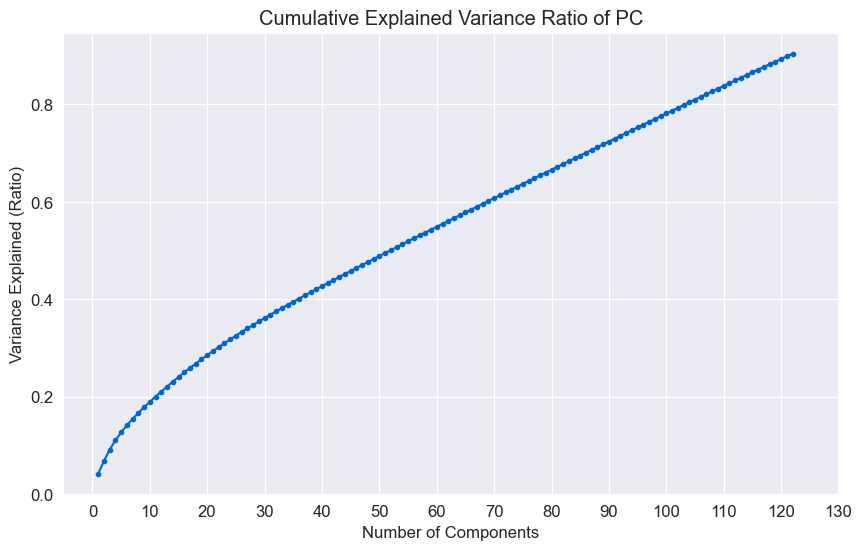

In [624]:
# Plot the cumsum of variance explained
plt.figure(figsize=(10,6))
plt.plot(range(1, num_pc+1), cumsum_pca, marker='.', c='#0066CC')
plt.title('Cumulative Explained Variance Ratio of PC')
plt.ylabel('Variance Explained (Ratio)')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, num_pc+10, 10))

plt.show()

- PCA for the upsampled Data

In [625]:
# Instantiate PCA for upsampled data
upsampled_pca = PCA(n_components=0.9)

# Fit PCA
upsampled_pca.fit(X_train_scaled_upsampled)

# Transform
X_train_pca_upsampled = upsampled_pca.transform(X_train_scaled_upsampled)
X_test_pca_upsampled = upsampled_pca.transform(X_test_scaled)

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


- PCA for the downsampled Data

In [626]:
# Instantiate PCA for downsampled data
downsampled_pca = PCA(n_components=0.9)

# Fit PCA on the scaled downsampled training data
downsampled_pca.fit(X_train_scaled_downsampled)

# Transform both the training and test datasets using the fitted PCA
X_train_pca_downsampled = downsampled_pca.transform(X_train_scaled_downsampled)
X_test_pca_downsampled = downsampled_pca.transform(X_test_scaled)

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


---

### 4.8 Additional preparations  <a class="anchor" id="4h"></a>

Create a function to calculate False Positive Rate (FPR)

In [627]:
# Create a function to calculate false positive rate
def false_positive_rate(y_test, y_pred):
    """"
    Calcualte the False Positive Rate
    fpr = fp / (fp + tn) where fp stands for false positives, and tn stands for true negatives

    Args:
        y_test(np.ndarray or pd.Series): True labels
        y_pred(np.ndarray or pd.Series): Predicted labels

    Returns:
        float: False positive rate
    """
    # Calculate false positives and true negatives
    fp = ((y_test == 0) & (y_pred == 1)).sum()
    tn = ((y_test == 0) & (y_pred == 0)).sum()

    # Handle edge case where sum of fp and tn is zero
    if (fp + tn) == 0:
        fpr = 0
    else: 
        # Calculate false positive rate
        fpr = round(fp / (fp + tn), 3)


    return fpr

---

Create a function to print various metrics of a trained machine learning model

In [628]:
def model_evaluation (X_train, X_test, y_train, y_test, model, is_neural_network=False):
    """
    Prints model evaluation metrics for both training and test datasets.
    Returns the probabilisitic and hard preditions for both training and test datasets.

    This function computes the predictions, and displays various classification metrics, including:
    confusion matrix, classification report, recall, false positive rate, accuracy, precision,
    F1, and AUC. It visualizes theconfusion matrix for the test data as well.

    Args:
        X_train (array): Feature set for the training data.
        X_test (array): Feature set for the test data.
        y_train (array): True labels for the training data.
        y_test (array): True labels for the test data.
        model (machine learning model): The trained model to evaluate.
        is_neural_network (bool): If True, use a different prediction method suitable for neural networks.
            Set default=False  

    Returns:
        tuple: A tuple containing:
            - y_pred_proba_train (array): Predicted probabilities for the training set.
            - y_pred_train (array): Hard predictions for the training set.
            - y_pred_proba_test (array): Predicted probabilities for the test set.
            - y_pred_test (array): Hard predictions for the test set.
    """

    # Predicted probabilities for train and test data
    if is_neural_network:
        y_pred_proba_train = model.predict(X_train)  # Use .predict for neural network soft predictions
        y_pred_proba_test = model.predict(X_test)
    else:
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]  # Use .predict_proba for traditional ML models
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

    # Hard Predictions for train and test data
    y_pred_train = np.where(y_pred_proba_train > 0.5, 1, 0).flatten()
    y_pred_test = np.where(y_pred_proba_test > 0.5, 1, 0).flatten()

    # Define print_line
    print_line = "\n" + "===========" * 6

    # Confusion Matrix
    print('Confusion matrices:', print_line)

    # Display confusion matrix for the test data
    plt.figure(figsize=(3, 3))
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
    plt.title('Confusion Matrix\nTest Data')
    plt.grid(False) 
    plt.show()

    # Print Classification Reports
    report_original = classification_report(y_test, y_pred_test)
    print('Test Data classification report: ', print_line, report_original)

    # Print Recall Score
    print('Recall Score:')
    print(f'Train: {recall_score(y_train, y_pred_train):.3f}')
    print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

    # Print False Positive Rate
    print('False Positive Rate:')
    print(f'Train: {false_positive_rate(y_train, y_pred_train):.3f}')
    print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

    # Print Accuracy Score
    print('Accuracy Score:')
    print(f'Train: {accuracy_score(y_train, y_pred_train):.3f}')
    print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

    # Print Precision Score
    print('Precision Score:')
    print(f'Train: {precision_score(y_train, y_pred_train):.3f}')
    print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

    # Print F1 Score
    print('F1 Score:')
    print(f'Train: {f1_score(y_train, y_pred_train):.3f}')
    print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

    # Print AUC Score
    print('AUC Score:')
    print(f'Train: {roc_auc_score(y_train, y_pred_proba_train):.3f}')
    print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

    # Return predictions and probabilities
    return y_pred_proba_train, y_pred_train, y_pred_proba_test, y_pred_test

---

Create two DataFrame to store the recall and false positive rate for each baseline models

In [629]:
# Create two DataFrames to store the metrics of best performer within each classification model
recall_best_model = pd.DataFrame(
    index=['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost', 'Neural Network'],
    columns=['Train', 'Test']
    )

fpr_best_model = pd.DataFrame(
    index=['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost', 'Neural Network'],
    columns=['Train', 'Test']
)

---

## 5. Baseline Modeling -  Logistic Regression <a class="anchor" id="5"></a>

### 5.1 Logistic Regression With Imbalanced Class (with class imbalance and scaling, without PCA) <a class="anchor" id="5a"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

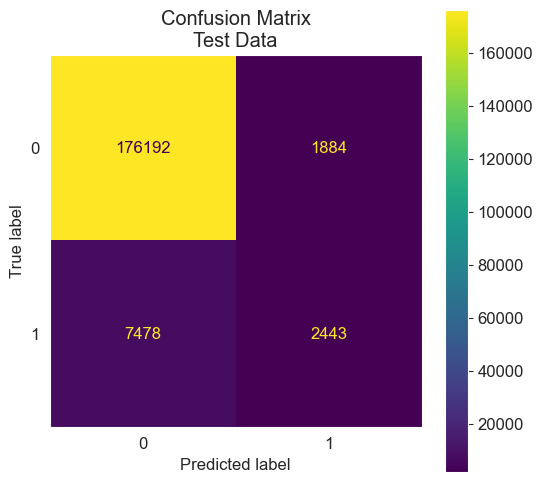

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.96      0.99      0.97    178076
           1       0.56      0.25      0.34      9921

    accuracy                           0.95    187997
   macro avg       0.76      0.62      0.66    187997
weighted avg       0.94      0.95      0.94    187997

Recall Score:
Train: 0.246
Test: 0.246 
False Positive Rate:
Train: 0.010
Test: 0.011 
Accuracy Score:
Train: 0.950
Test: 0.950 
Precision Score:
Train: 0.571
Test: 0.565 
F1 Score:
Train: 0.344
Test: 0.343 
AUC Score:
Train: 0.887
Test: 0.884 


In [630]:
###MODEL FITTING###

# Fit logictic Regression on Imbalanced Data
logit_imbalanced = LogisticRegression(max_iter=1000, random_state=42)
logit_imbalanced.fit(X_train_scaled, y_train)


##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled,
    X_test_scaled, 
    y_train, 
    y_test, 
    logit_imbalanced
    )

---

### 5.2 Logistic Regression With Upsampling (scaled, without PCA) <a class="anchor" id="5b"></a>

Confusion matrices: 


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<Figure size 300x300 with 0 Axes>

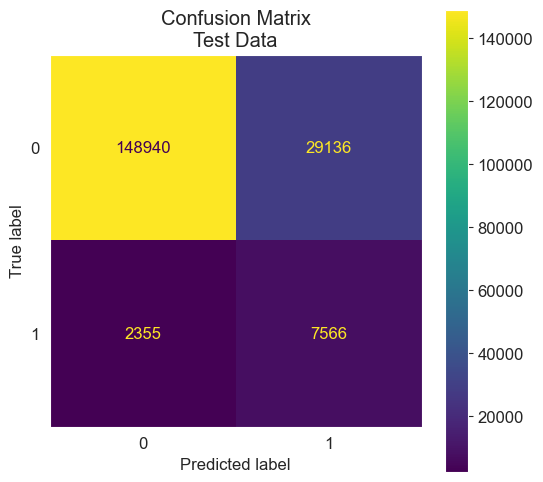

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.90    178076
           1       0.21      0.76      0.32      9921

    accuracy                           0.83    187997
   macro avg       0.60      0.80      0.61    187997
weighted avg       0.94      0.83      0.87    187997

Recall Score:
Train: 0.767
Test: 0.763 
False Positive Rate:
Train: 0.163
Test: 0.164 
Accuracy Score:
Train: 0.802
Test: 0.832 
Precision Score:
Train: 0.825
Test: 0.206 
F1 Score:
Train: 0.795
Test: 0.325 
AUC Score:
Train: 0.888
Test: 0.885 


In [631]:
###############
#MODEL FITTING#
###############

# Upsampled Data
logit_upsampled = LogisticRegression(max_iter=1000, random_state=42)
logit_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_upsampled, 
    X_test_scaled, 
    y_train_upsampled, 
    y_test, 
    logit_upsampled
)

In [632]:
# Since this is the best performer, store the metrics in the DataFrame
recall_best_model.loc['Logistic Regression', :] = [
    recall_score(y_train_upsampled, y_pred_train).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_best_model.loc['Logistic Regression', :] = [
    false_positive_rate(y_train_upsampled, y_pred_train).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---

#### Model Interpretation

- In logistic regression, a feature with the greatest positive coefficient has the most predictive power for predicting the positive class, while a feature with a significant negative coefficient indicates a greater likelihood of predicting the negative class.
- In this section, I will interpret the top 15 features that have the greatest predictive power for experiencing a heart attack (Class 1), as well as the top 15 features for not experiencing a heart attack (Class 0). Specifically, I will:

    1. Generate a sorted list of the 15 features with their coefficients, ordered from highest to lowest.
    2. Generate a sorted list of the 15 features with their coefficients (negative numbers), ordered from lowest to highest.
    3. Visualize the top 15 features from each list.

In [633]:
# Fetch the coefficients and corresponding feature name
logit_upsampled_coefficients = pd.Series(logit_upsampled.coef_[0], index=X_train_encoded.columns)

In [634]:
# Find the top 15 and bottom 15 features that predicting a heart attack
top15_coef = logit_upsampled_coefficients.sort_values(ascending=False).head(15)
bottom15_coef = logit_upsampled_coefficients.sort_values().head(15)

In [635]:
# Create a list to store all the important features in logreg
logreg_important_features = top15_coef.index.tolist() + bottom15_coef.index.tolist()

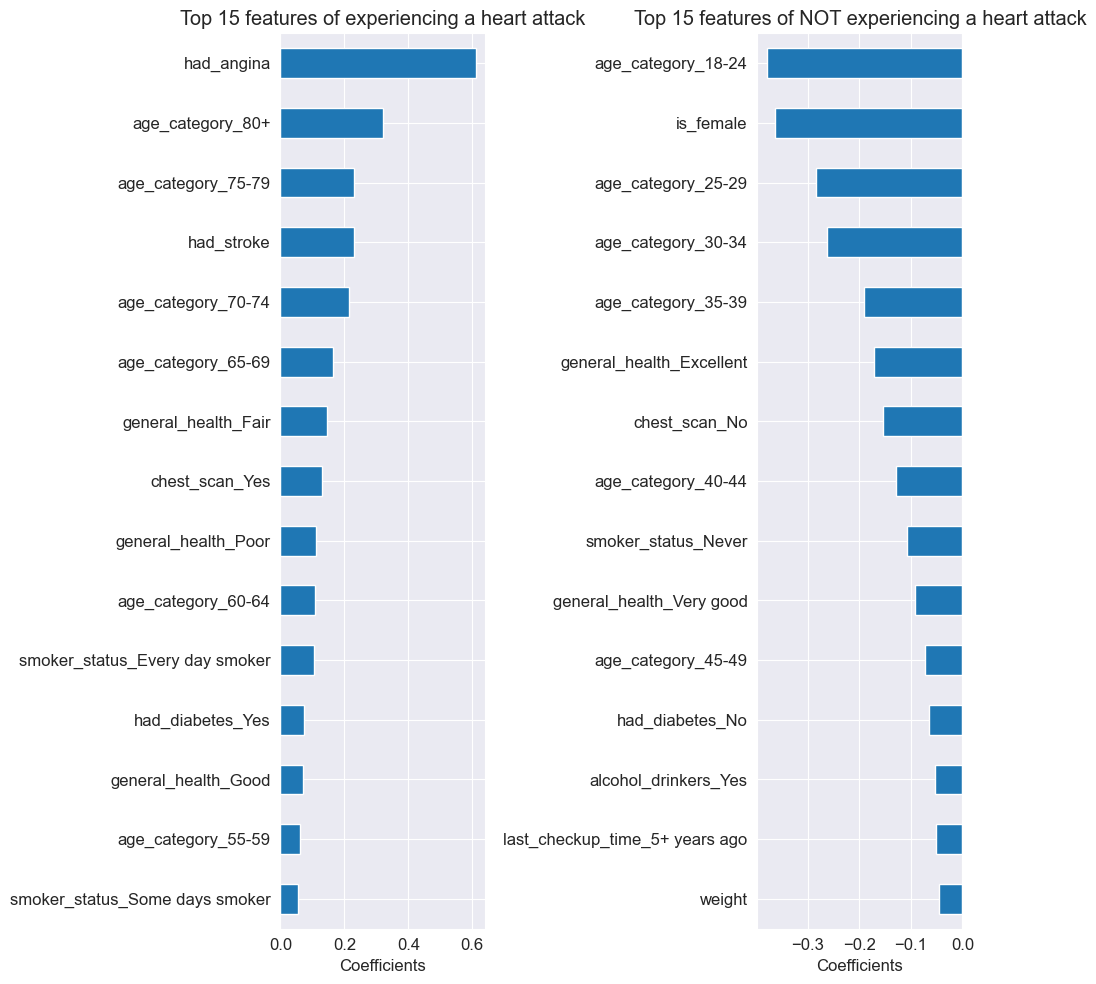

In [636]:
# Instantiate a subplot
fig, axes = plt.subplots(1, 2 , figsize=(10, 10))

# Create the plot of 15 largest coefficients
top15_coef.sort_values().plot(kind='barh', legend=False, ax=axes[0])
axes[0].set_title('Top 15 features of experiencing a heart attack')
axes[0].set_xlabel('Coefficients')


# Create the plot of 20 smallest coefficients
bottom15_coef.sort_values(ascending=False).plot(kind='barh', legend=False, ax=axes[1])
axes[1].set_title('Top 15 features of NOT experiencing a heart attack')
axes[1].set_xlabel('Coefficients')

plt.tight_layout()
plt.show()

In [637]:
# get the largest positive coefficient, and calculate the odds
print(f'Top predictive feature of positive instance: {top15_coef.index[0]}')
print(f'Coefficient: {top15_coef.values[0]}')
print(f'Odds: {np.exp(top15_coef.values[0]):.2f}')

Top predictive feature of positive instance: had_angina
Coefficient: 0.6106612913288668
Odds: 1.84


In [638]:
# get the smallest negative coefficient, and calculate the odds
print(f'Top predictive feature of negative instance: {bottom15_coef.index[0]}')
print(f'Coefficient: {bottom15_coef.values[0]}')
print(f'Odds: {np.exp(bottom15_coef.values[0]):.2f}')

Top predictive feature of negative instance: age_category_18-24
Coefficient: -0.37910381786785774
Odds: 0.68


**Coefficient Interpretation:**<br>
Top predictive word in having a heart attack and not having a heart attack:
| Parameter                   | Coefficient   | Calculation     | Result | Interpretation                                                                 |
|:----------------------------|:--------------|:----------------|:-------|:------------------------------------------------------------------------------|
| **had_angina**    | 0.61         | $e^{0.61}$   | 1.84  | Individuals whose had experienced angina have higher odds of having a heart attack. One standard deviation increase in the presence of angina will lead to an approximate odds increase of 1.84 times. |
| **age_category_18-24**    | -0.38      | $e^{-0.38}$   | 0.68  | Individuals whose age is 18-24 have much lower odds of having a heart attack. One standard deviation increase in the presence of age 18-24 will lead to an approximate odds decrease of 0.68 times. |


---

---

### 5.3 Logistic Regression With Downsampling (scaled, without PCA) <a class="anchor" id="5c"></a>

Confusion matrices: 


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<Figure size 300x300 with 0 Axes>

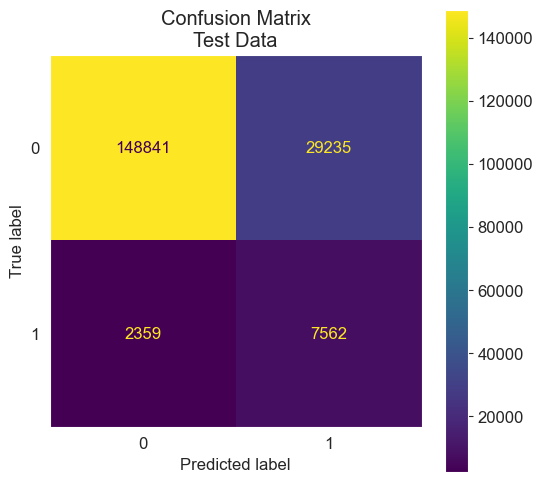

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.90    178076
           1       0.21      0.76      0.32      9921

    accuracy                           0.83    187997
   macro avg       0.59      0.80      0.61    187997
weighted avg       0.94      0.83      0.87    187997

Recall Score:
Train: 0.767
Test: 0.762 
False Positive Rate:
Train: 0.161
Test: 0.164 
Accuracy Score:
Train: 0.803
Test: 0.832 
Precision Score:
Train: 0.826
Test: 0.206 
F1 Score:
Train: 0.795
Test: 0.324 
AUC Score:
Train: 0.888
Test: 0.884 


In [639]:
###############
# MODEL FITTING#
###############

# Downsampled Data
logit_downsampled = LogisticRegression(max_iter=1000, random_state=42)
logit_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_downsampled, 
    X_test_scaled, 
    y_train_downsampled, 
    y_test, 
    logit_downsampled
    )

---

### 5.4 Logistic Regression With Oversampling (scaled, without PCA) <a class="anchor" id="5d"></a>

Confusion matrices: 


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<Figure size 300x300 with 0 Axes>

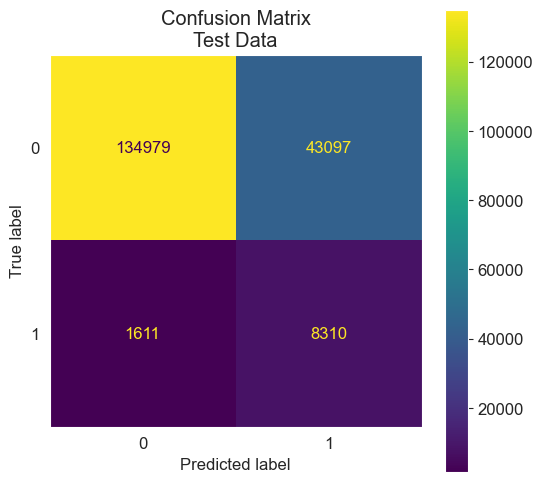

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.99      0.76      0.86    178076
           1       0.16      0.84      0.27      9921

    accuracy                           0.76    187997
   macro avg       0.57      0.80      0.56    187997
weighted avg       0.94      0.76      0.83    187997

Recall Score:
Train: 0.843
Test: 0.838 
False Positive Rate:
Train: 0.242
Test: 0.242 
Accuracy Score:
Train: 0.809
Test: 0.762 
Precision Score:
Train: 0.839
Test: 0.162 
F1 Score:
Train: 0.841
Test: 0.271 
AUC Score:
Train: 0.888
Test: 0.885 


In [640]:
###############
# MODEL FITTING #
###############

# Oversampled Data
logit_oversampled = LogisticRegression(max_iter=1000, random_state=42)
logit_oversampled.fit(X_train_scaled_oversampled, y_train_oversampled)

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_oversampled, 
    X_test_scaled, 
    y_train_oversampled, 
    y_test, 
    logit_oversampled
    )

- While the model shows an improvement in the Recall score compared to other methods, it exhibits signs of overfitting, as evidenced by a notably lower accuracy score on the test set relative to the training accuracy. Consequently, oversampling does not appear to be an effective method for enhancing model performance.

---

### 5.5 Best Model with PCA - Logistic Regression With Upsampling and PCA <a class="anchor" id="5e"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

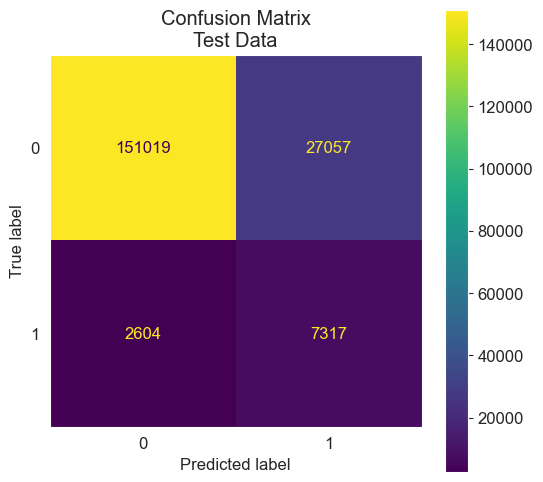

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.85      0.91    178076
           1       0.21      0.74      0.33      9921

    accuracy                           0.84    187997
   macro avg       0.60      0.79      0.62    187997
weighted avg       0.94      0.84      0.88    187997

Recall Score:
Train: 0.745
Test: 0.738 
False Positive Rate:
Train: 0.152
Test: 0.152 
Accuracy Score:
Train: 0.797
Test: 0.842 
Precision Score:
Train: 0.831
Test: 0.213 
F1 Score:
Train: 0.785
Test: 0.330 
AUC Score:
Train: 0.882
Test: 0.879 


In [641]:
###############
#MODEL FITTING#
###############

# Upsampled Data with PCA
logit_upsampled_pca = LogisticRegression(max_iter=1000, random_state=42)
logit_upsampled_pca.fit(X_train_pca_upsampled, y_train_upsampled)

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_pca_upsampled, 
    X_test_pca_upsampled, 
    y_train_upsampled, 
    y_test, 
    logit_upsampled_pca
    )

---

### 5.6 Logistic Regression Baseline Modeling Summary <a class="anchor" id="5f"></a>

**Metrics using test data:**
| Model                   | PCA | Recall | FPR  | Accuracy | Precision | F1 Score | AUC   | Notes                                             |
|-------------------------|-----|--------|------|----------|-----------|----------|-------|---------------------------------------------------|
| Logistic Regression      | No  | 0.246  | 0.011| 0.950    | 0.565     | 0.343    | 0.884 | Imbalanced                                        |
| **Logistic Regression**      | No  | **0.763**  | **0.164** | 0.832    | 0.206     | 0.325    | 0.885 | **Upsampled**                                      |
| Logistic Regression      | No  | 0.762  | 0.164 | 0.832    | 0.206     | 0.324    | 0.884 | Downsampled                                       |
| Logistic Regression      | No  | 0.838  | 0.242 | 0.762    | 0.162     | 0.271    | 0.885 | Oversampled (60% Class 1), Overfitting in accuracy   |
| Logistic Regression      | Yes | 0.738  | 0.152 | 0.842    | 0.213     | 0.330    | 0.879  | Upsampled, PCA set at n_components=0.9          |



- By far, hyperparameter tuning has not been performed on any of the Logistic Regression models. The models utilizing upsampling and downsampling demonstrate very similar performance, with the upsampling model achieving slightly better recall metrics.

- After applying oversampling to increase the number of Class 1 (heart attack) observations, Class 1 now comprises 60% of the labels in the training set. This adjustment resulted in a 7.5% improvement in the recall score. However, it also led to a 7.8% increase in the false positive rate. Additionally, indications of overfitting were observed, as evidenced by a noticeable gap between the accuracy on the training data and the accuracy on the test data.

- The model with PCA performed worse than the best performer, suggesting that the features may contain important non-linear relationships that PCA fails to capture. Consequently, valuable information may have been lost during the dimensionality reduction process.

- All models trained on balanced datasets (upsampling, downsampling, oversampling) exhibit a significant gap in the precision score between training and test data. This discrepancy may be attributed to overfitting, especially given that the baseline models consist of 149 features. Additionally, the imbalance distribution in the test set plays a critical role. Recall the formula for $\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}$. In the test set, where negatives comprise 94.7% of the data, even a small false positive rate can result in a substantial number of false positives. This increase in false positives ultimately reduces the precision score, causing the discrepancy in train and test precision.

---

## 6 Baseline Modeling - Naive Bayes  <a class="anchor" id="6"></a>

### 6.1 Naive Bayes With Imbalanced Class (with class imbalance and scaling, without PCA) <a class="anchor" id="6a"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

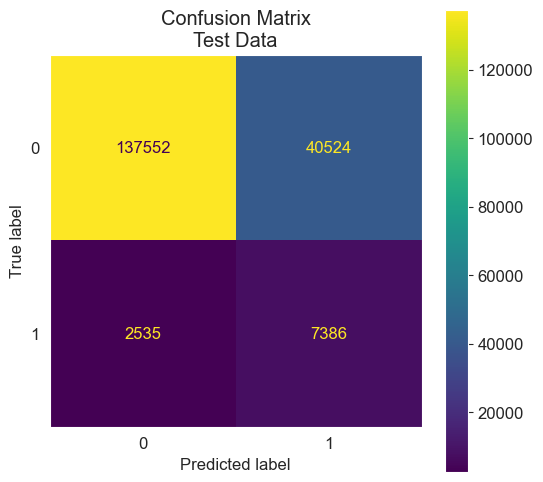

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.77      0.86    178076
           1       0.15      0.74      0.26      9921

    accuracy                           0.77    187997
   macro avg       0.57      0.76      0.56    187997
weighted avg       0.94      0.77      0.83    187997

Recall Score:
Train: 0.744
Test: 0.744 
False Positive Rate:
Train: 0.228
Test: 0.228 
Accuracy Score:
Train: 0.771
Test: 0.771 
Precision Score:
Train: 0.154
Test: 0.154 
F1 Score:
Train: 0.255
Test: 0.255 
AUC Score:
Train: 0.823
Test: 0.823 


In [642]:
###############
#MODEL FITTING#
###############

# Imbalanced Data
nbmodel_imbalanced = GaussianNB()
nbmodel_imbalanced.fit(X_train_scaled, y_train)


##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled,
    X_test_scaled, 
    y_train, 
    y_test, 
    nbmodel_imbalanced
    )

---

### 6.2 Naive Bayes With Upsampling (scaled, without PCA) <a class="anchor" id="6b"></a>

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


Confusion matrices: 


<Figure size 300x300 with 0 Axes>

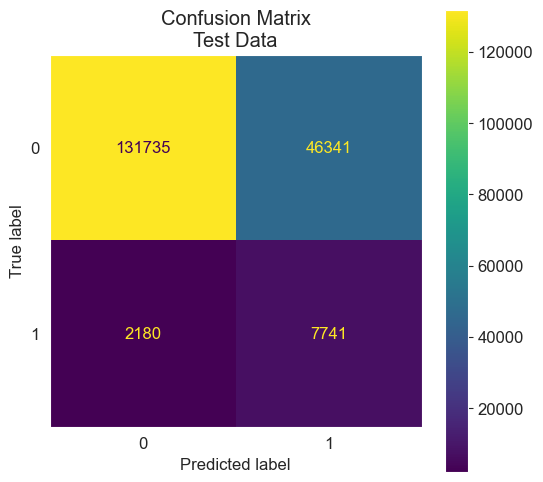

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.74      0.84    178076
           1       0.14      0.78      0.24      9921

    accuracy                           0.74    187997
   macro avg       0.56      0.76      0.54    187997
weighted avg       0.94      0.74      0.81    187997

Recall Score:
Train: 0.780
Test: 0.780 
False Positive Rate:
Train: 0.260
Test: 0.260 
Accuracy Score:
Train: 0.760
Test: 0.742 
Precision Score:
Train: 0.750
Test: 0.143 
F1 Score:
Train: 0.765
Test: 0.242 
AUC Score:
Train: 0.823
Test: 0.822 


In [643]:
###############
#MODEL FITTING#
###############

# Upsampled Data
nbmodel_upsampled = GaussianNB()
nbmodel_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_upsampled, 
    X_test_scaled, 
    y_train_upsampled, 
    y_test, 
    nbmodel_upsampled
)

In [644]:
# Since this is the best performer, store the metrics in the DataFrame
recall_best_model.loc['Naive Bayes', :] = [
    recall_score(y_train_upsampled, y_pred_train).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_best_model.loc['Naive Bayes', :] = [
    false_positive_rate(y_train_upsampled, y_pred_train).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---

#### 6.3 Naive Bayes With Downsampling (scaled, without PCA) <a class="anchor" id="6c"></a>

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


Confusion matrices: 


<Figure size 300x300 with 0 Axes>

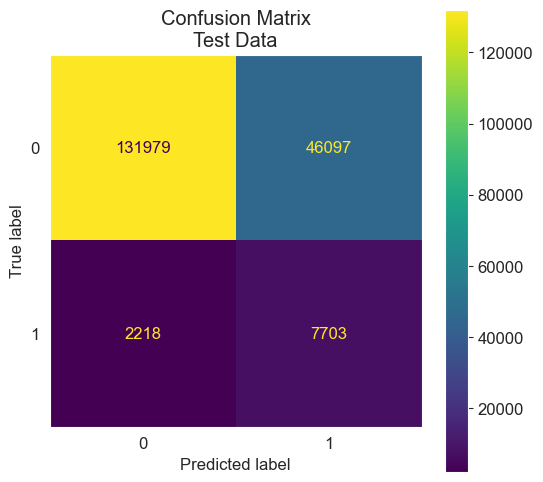

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.74      0.85    178076
           1       0.14      0.78      0.24      9921

    accuracy                           0.74    187997
   macro avg       0.56      0.76      0.54    187997
weighted avg       0.94      0.74      0.81    187997

Recall Score:
Train: 0.777
Test: 0.776 
False Positive Rate:
Train: 0.256
Test: 0.259 
Accuracy Score:
Train: 0.760
Test: 0.743 
Precision Score:
Train: 0.752
Test: 0.143 
F1 Score:
Train: 0.764
Test: 0.242 
AUC Score:
Train: 0.823
Test: 0.821 


In [645]:
###############
# MODEL FITTING #
###############

# Fit Gaussian Naive Bayes on Downsampled Data
nbmodel_downsampled = GaussianNB()
nbmodel_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)


##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_downsampled, 
    X_test_scaled, 
    y_train_downsampled, 
    y_test, 
    nbmodel_downsampled
    )

---

### 6.4 Naive Bayes Baseline Modeling Summary <a class="anchor" id="6d"></a>

**Metrics using test data:**
| Model                   | PCA | Recall | FPR  | Accuracy | Precision | F1 Score | AUC   | Notes                       |
|-------------------------|-----|--------|------|----------|-----------|----------|-------|-----------------------------|
| Naive Bayes             | No  | 0.744  | 0.228| 0.771    | 0.154     | 0.267    | 0.824 | Imbalanced                 |
| **Naive Bayes**             | No  | **0.780**  | **0.260**| 0.742    | 0.143     | 0.242    | 0.822 | **Upsampled**    |
| Naive Bayes         | No| 0.776| 0.259| 0.743| 0.143| 0.242| 0.821 | Downsampled |

- By far, hyperparameter tuning has not been performed on any of the Naive Bayes models. The models utilizing upsampling and downsampling demonstrate very similar performance, with the downsampling model achieving slightly better Recall metrics.
- Compared to the imbalanced Logistic Regression model, the Naive Bayes model demonstrates a significantly higher Recall score at the expense of Accuracy and Precision. This can be attributed to the fundamental nature of Naive Bayes, which calculates probabilities based on class distributions, allowing for better identification of the minority class in the context of an imbalanced distribution.

---



## 7 Baseline Modeling - Decision Tree  <a class="anchor" id="7"></a>

### 7.1 Decision Tree Imbalanced (with class imbalance and scaling, without PCA) <a class="anchor" id="7a"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

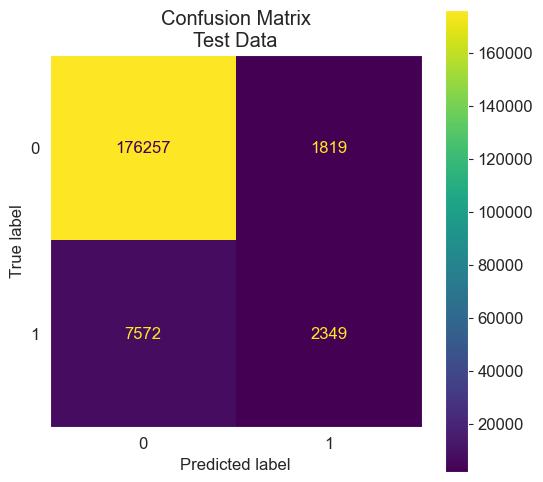

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.96      0.99      0.97    178076
           1       0.56      0.24      0.33      9921

    accuracy                           0.95    187997
   macro avg       0.76      0.61      0.65    187997
weighted avg       0.94      0.95      0.94    187997

Recall Score:
Train: 0.244
Test: 0.237 
False Positive Rate:
Train: 0.009
Test: 0.010 
Accuracy Score:
Train: 0.951
Test: 0.950 
Precision Score:
Train: 0.590
Test: 0.564 
F1 Score:
Train: 0.345
Test: 0.333 
AUC Score:
Train: 0.859
Test: 0.855 


In [646]:
###############
# MODEL FITTING #
###############

# Fit Decision Tree Classifier on Imbalanced Data
dt_imbalanced = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_imbalanced.fit(X_train_scaled, y_train)  # Using the original scaled data

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled,
    X_test_scaled, 
    y_train, 
    y_test, 
    dt_imbalanced
    )


---

### 7.2 Decision Tree With Upsampling (scaled, without PCA) <a class="anchor" id="7b"></a>

Confusion matrices: 


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Figure size 300x300 with 0 Axes>

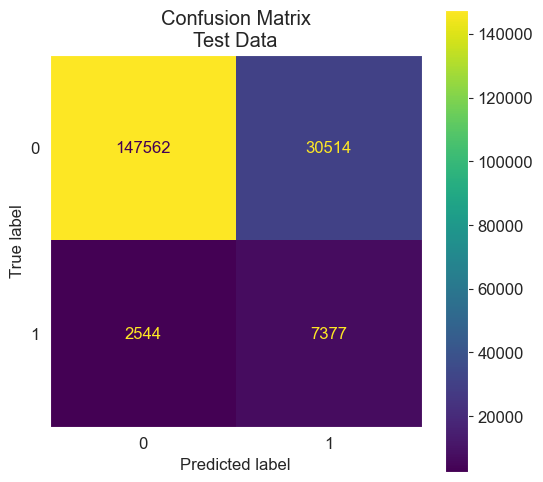

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.83      0.90    178076
           1       0.19      0.74      0.31      9921

    accuracy                           0.82    187997
   macro avg       0.59      0.79      0.60    187997
weighted avg       0.94      0.82      0.87    187997

Recall Score:
Train: 0.754
Test: 0.744 
False Positive Rate:
Train: 0.171
Test: 0.171 
Accuracy Score:
Train: 0.791
Test: 0.824 
Precision Score:
Train: 0.815
Test: 0.195 
F1 Score:
Train: 0.783
Test: 0.309 
AUC Score:
Train: 0.862
Test: 0.856 


In [647]:
###############
#MODEL FITTING#
###############

# Upsampled Data
dt_upsampled = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_upsampled, 
    X_test_scaled, 
    y_train_upsampled, 
    y_test, 
    dt_upsampled
)

In [648]:
# Since this is the best performer, store the metrics in the DataFrame
recall_best_model.loc['Decision Tree', :] = [
    recall_score(y_train_upsampled, y_pred_train).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_best_model.loc['Decision Tree', :] = [
    false_positive_rate(y_train_upsampled, y_pred_train).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---

#### Model Interpretation

The Decision model includes a feature importance metric that measures how much each feature contributes to the model's predictions. Features with higher importance scores are considered more impactful within the model. In this section, I will:
1. Find the top 30 features with the highest importance scores.
2. Visualize the most influential features.

In [649]:
# Get feature importances
dt_importances = dt_upsampled.feature_importances_

# Create a DataFrame with features and Feature importances
dt_feature_importance_df = pd.DataFrame(
    dt_importances.reshape(-1, 1),
    index=X_train.columns,
    columns=['feature_importance']
)

# Sort by the feature importance and show the top five rows
dt_feature_importance_df = dt_feature_importance_df.sort_values(by='feature_importance', ascending=False)
dt_feature_importance_df.head(5)

,feature_importance
had_angina,0.660941
difficulty_walking_No,0.113679
had_stroke,0.076999
had_diabetes_Yes,0.041256
age_category_80+,0.034862


<Figure size 1500x1500 with 0 Axes>

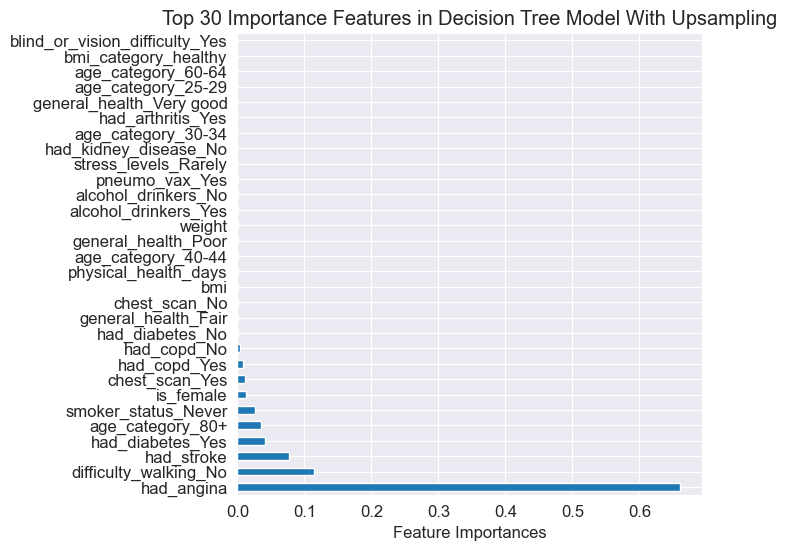

In [650]:
# Visualize the top 40 important features
plt.figure(figsize=(15, 15))
dt_feature_importance_df.head(30).plot(kind='barh', legend=False)
plt.title('Top 30 Importance Features in Decision Tree Model With Upsampling')
plt.xlabel('Feature Importances')

plt.show()

In [651]:
# Create a list of 11 important features in Decision Tree
dt_important_features = dt_feature_importance_df.head(11).index.tolist()

dt_important_features

['had_angina',
 'difficulty_walking_No',
 'had_stroke',
 'had_diabetes_Yes',
 'age_category_80+',
 'smoker_status_Never',
 'is_female',
 'chest_scan_Yes',
 'had_copd_Yes',
 'had_copd_No',
 'had_diabetes_No']

**Takeaways**:
- In the Decision Tree model, only 11 out of 149 features (ranging from `chest_scan_yes` to `had_angina`) were found to significantly contribute to predicting the risk of experiencing a heart attack. This indicates that a vast number of features were deemed unimportant, potentially leading to overfitting. 
- The presence of many irrelevant features likely contributes to the gap between the recall on the training and test datasets. Reducing or refining the feature set could help mitigate this issue and improve model generalization.
---

### 7.3 Decision Tree With Downsampling (scaled, without PCA) <a class="anchor" id="7c"></a>

Confusion matrices: 


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Figure size 300x300 with 0 Axes>

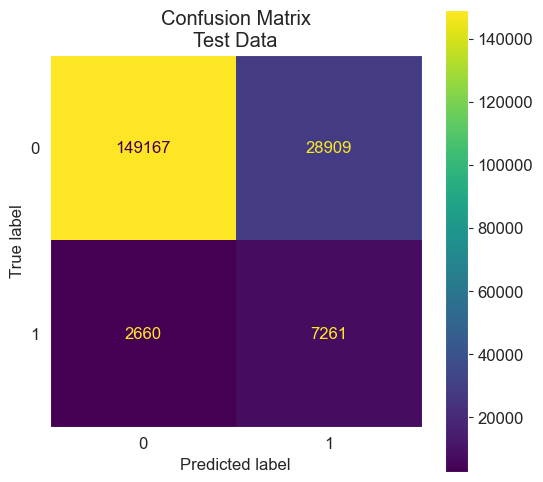

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.90    178076
           1       0.20      0.73      0.32      9921

    accuracy                           0.83    187997
   macro avg       0.59      0.78      0.61    187997
weighted avg       0.94      0.83      0.87    187997

Recall Score:
Train: 0.744
Test: 0.732 
False Positive Rate:
Train: 0.159
Test: 0.162 
Accuracy Score:
Train: 0.792
Test: 0.832 
Precision Score:
Train: 0.823
Test: 0.201 
F1 Score:
Train: 0.781
Test: 0.315 
AUC Score:
Train: 0.863
Test: 0.854 


In [652]:
###############
# MODEL FITTING #
###############

# Downsampled Data
dt_downsampled = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_downsampled, 
    X_test_scaled, 
    y_train_downsampled, 
    y_test, 
    dt_downsampled
    )

---

### 7.4 Decision Tree Baseline Modeling Summary <a class="anchor" id="7d"></a>

**Metrics using test data:**<br>
All Models uses hyperparameters: max_depth=7 
| Model                   | PCA | Recall | FPR  | Accuracy | Precision | F1 Score | AUC   | Notes                               |
|-------------------------|-----|--------|------|----------|-----------|----------|-------|-------------------------------------|
| Decision Tree           | No  | 0.237  | 0.010| 0.950    | 0.564     | 0.333    | 0.855 | Imbalanced                          |
| **Decision Tree**           | No  | **0.744**  | **0.171**| 0.824    | 0.195     | 0.309    | 0.856 | **Upsampled**              |
| Decision Tree       | No| 0.732 | 0.162| 0.832| 0.201| 0.315| 0.854 | Downsampled      |



- So far, hyperparameter tuning has not been conducted on any of the Decision models. Due to the tendency of Decision Trees to overfit the data, I have set the maximum depth to 7 across all baseline models. 
- The Decision Tree model with upsampling achieves the highest recall score, and its fpr is just slightly higher than the model with downsampling I will select this model as the best performer.
- In the model interpretation of Decision Tree Model With Upsampling model, only 11 out of 149 features were found to significantly contribute to predicting the target. A vast number of unimportant features could potentially lead to overfitting, so reducing the feature could help improve generalization.
- All models trained on balanced datasets (upsampling, downsampling, oversampling) exhibit a significant gap in the precision score between training and test data. This discrepancy may be attributed to overfitting, especially given that the baseline models consist of 149 features. Additionally, the imbalance distribution in the test set plays a critical role. Recall the formula for $\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}$. In the test set, where negatives comprise 94.7% of the data, even a small false positive rate can result in a substantial number of false positives. This increase in false positives ultimately reduces the precision score, causing the discrepancy in train and test precision.

---




## 8 Baseline Modeling - Random Forest  <a class="anchor" id="8"></a>

### 8.1 Random Forest Imbalanced (with class imbalance and scaling, without PCA) <a class="anchor" id="8a"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

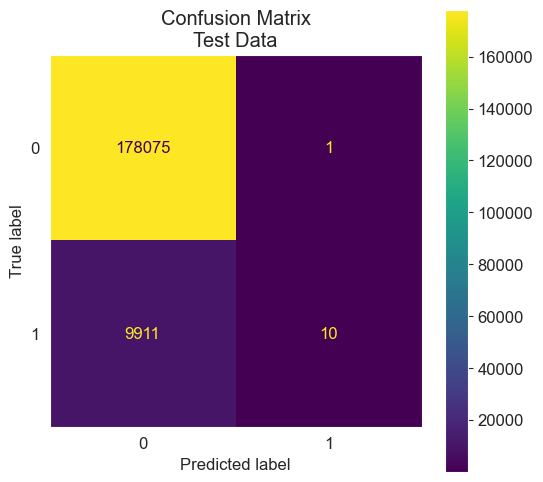

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.95      1.00      0.97    178076
           1       0.91      0.00      0.00      9921

    accuracy                           0.95    187997
   macro avg       0.93      0.50      0.49    187997
weighted avg       0.95      0.95      0.92    187997

Recall Score:
Train: 0.002
Test: 0.001 
False Positive Rate:
Train: 0.000
Test: 0.000 
Accuracy Score:
Train: 0.947
Test: 0.947 
Precision Score:
Train: 0.864
Test: 0.909 
F1 Score:
Train: 0.004
Test: 0.002 
AUC Score:
Train: 0.878
Test: 0.874 


In [653]:
###############
# MODEL FITTING #
###############

# Fit Random Forest Classifier on Imbalanced Data
rf_imbalanced = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42)
rf_imbalanced.fit(X_train_scaled, y_train)  

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled,
    X_test_scaled, 
    y_train, 
    y_test, 
    rf_imbalanced
    )

---

### 8.2 Random Forest With Upsampling (scaled, without PCA) <a class="anchor" id="8b"></a>

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Confusion matrices: 


<Figure size 300x300 with 0 Axes>

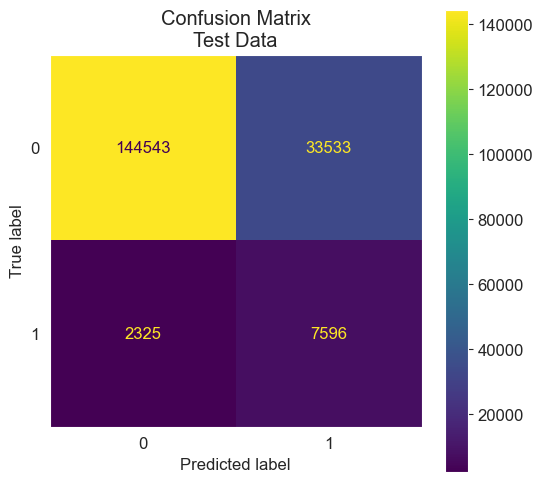

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.81      0.89    178076
           1       0.18      0.77      0.30      9921

    accuracy                           0.81    187997
   macro avg       0.58      0.79      0.59    187997
weighted avg       0.94      0.81      0.86    187997

Recall Score:
Train: 0.775
Test: 0.766 
False Positive Rate:
Train: 0.188
Test: 0.188 
Accuracy Score:
Train: 0.793
Test: 0.809 
Precision Score:
Train: 0.805
Test: 0.185 
F1 Score:
Train: 0.789
Test: 0.298 
AUC Score:
Train: 0.876
Test: 0.871 


In [654]:
###############
#MODEL FITTING#
###############

# Upsampled Data
rf_upsampled = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42)
rf_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)  

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_upsampled, 
    X_test_scaled, 
    y_train_upsampled, 
    y_test, 
    rf_upsampled
)

In [655]:
# Since this is the best performer, store the metrics in the DataFrame
recall_best_model.loc['Random Forest', :] = [
    recall_score(y_train_upsampled, y_pred_train).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_best_model.loc['Random Forest', :] = [
    false_positive_rate(y_train_upsampled, y_pred_train).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---

#### Model Interpretation

The Random Forest model includes a feature importance metric that measures how much each feature contributes to the model's predictions. Features with higher importance scores are considered more impactful within the model. In this section, I will:
1. Find the top 30 features with the highest importance scores.
2. Visualize the most influential features.

In [656]:
# Retrieve the feature importances from Random Forest with downsampling model
rf_importances = rf_upsampled.feature_importances_

# Create a DataFrame of each feature and its importance in Random Forest Model
rf_feature_importance_df = pd.DataFrame(rf_importances.reshape(-1, 1), 
                                     index= X_train.columns,
                                     columns=['feature_importance'])

# Sort the feature importance DataFramce and show top five rows
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='feature_importance', ascending=False)

rf_feature_importance_df.head()

,feature_importance
had_angina,0.344806
pneumo_vax_Yes,0.075248
difficulty_walking_No,0.067794
had_stroke,0.064457
had_diabetes_No,0.035940


<Figure size 1500x1500 with 0 Axes>

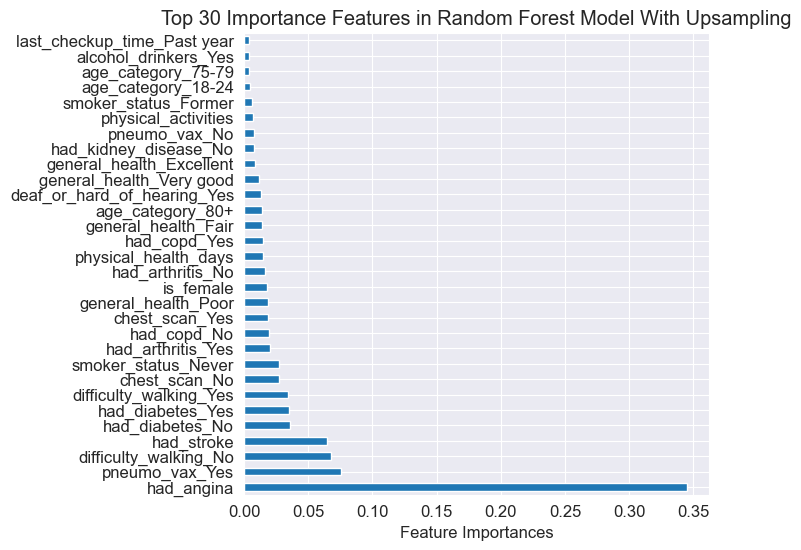

In [657]:
# Visualize the top 40 important features
plt.figure(figsize=(15, 15))
rf_feature_importance_df.head(30).plot(kind='barh', legend=False)
plt.title('Top 30 Importance Features in Random Forest Model With Upsampling')
plt.xlabel('Feature Importances')

plt.show()

In [658]:
# Create a list of important features from Random Forest
rf_important_features = rf_feature_importance_df.head(30).index.tolist()

rf_important_features


['had_angina',
 'pneumo_vax_Yes',
 'difficulty_walking_No',
 'had_stroke',
 'had_diabetes_No',
 'had_diabetes_Yes',
 'difficulty_walking_Yes',
 'chest_scan_No',
 'smoker_status_Never',
 'had_arthritis_Yes',
 'had_copd_No',
 'chest_scan_Yes',
 'general_health_Poor',
 'is_female',
 'had_arthritis_No',
 'physical_health_days',
 'had_copd_Yes',
 'general_health_Fair',
 'age_category_80+',
 'deaf_or_hard_of_hearing_Yes',
 'general_health_Very good',
 'general_health_Excellent',
 'had_kidney_disease_No',
 'pneumo_vax_No',
 'physical_activities',
 'smoker_status_Former',
 'age_category_18-24',
 'age_category_75-79',
 'alcohol_drinkers_Yes',
 'last_checkup_time_Past year']

**Takeaways**:
- Compared to the Decision Tree model, a greater number of features contributed to the prediction of the target variable in the Random Forest model. However, the proportion of important features remains relatively low, as there are clearly fewer than 30 important features out of a total of 149.
- By comparing the important features in the Decision Tree and Logistic Regression models, I found that many of the top-ranked important features in the Random Forest model, such as `had_angina`, `difficult_walking_Yes`, `had_stroke`, and `age_category_80+`,etc., are also considered important across the other models. This suggests a consistent identification of key predictors among the different modeling approaches.
---

### 8.3 Random Forest With Downsampling (scaled, without PCA) <a class="anchor" id="8c"></a>

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Confusion matrices: 


<Figure size 300x300 with 0 Axes>

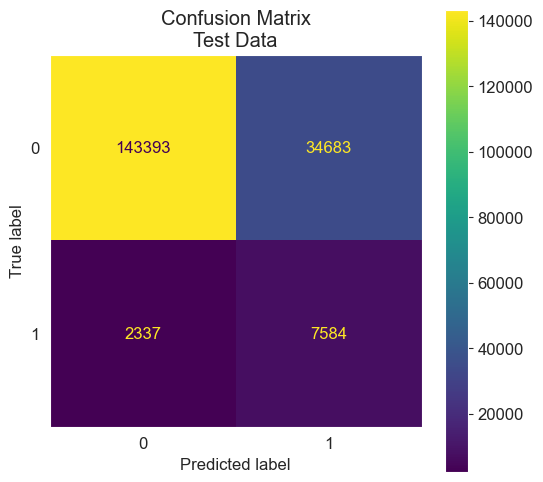

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.81      0.89    178076
           1       0.18      0.76      0.29      9921

    accuracy                           0.80    187997
   macro avg       0.58      0.78      0.59    187997
weighted avg       0.94      0.80      0.85    187997

Recall Score:
Train: 0.773
Test: 0.764 
False Positive Rate:
Train: 0.191
Test: 0.195 
Accuracy Score:
Train: 0.791
Test: 0.803 
Precision Score:
Train: 0.802
Test: 0.179 
F1 Score:
Train: 0.787
Test: 0.291 
AUC Score:
Train: 0.874
Test: 0.868 


In [659]:
###############
#MODEL FITTING#
###############

# Downsampled Data
rf_downsampled = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42)
rf_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)  

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_downsampled, 
    X_test_scaled, 
    y_train_downsampled, 
    y_test, 
    rf_downsampled
    )

In [660]:
# Since this is the best performer, store the metrics in the DataFrame
recall_best_model.loc['Random Forest', :] = [
    recall_score(y_train_downsampled, y_pred_train).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_best_model.loc['Random Forest', :] = [
    false_positive_rate(y_train_downsampled, y_pred_train).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---




### 8.4 Random Forest Baseline Modeling Summary  <a class="anchor" id="8d"></a>

**Metrics using test data:**<br>
All Models uses hyperparameters: n_estimators=50, max_depth=7 
| Model                   | PCA | Recall | FPR  | Accuracy | Precision | F1 Score | AUC   | Notes                       |
|-------------------------|-----|--------|------|----------|-----------|----------|-------|-----------------------------|
| Random Forest           | No  | 0.001  | 0.000| 0.947    | 0.909    | 0.002    | 0.874 | Imbalanced                  |
| **Random Forest**       | No  | **0.766**  | **0.188**| 0.809    | 0.185     | 0.298    | 0.871 | **Upsampled** |
| Random Forest          | No  | 0.764  | 0.195| 0.803    | 0.179     | 0.291   | 0.868 | Downsampled   |


- So far, hyperparameter tuning has not been conducted on any of the Random Forest models. Due to the tendency of Decision Trees to overfit the data, I have set the maximum depth to 7 across all baseline models. The models utilizing both upsampling and downsampling exhibit very similar performance, with the upampling model achieving slightly better Recall metrics.
- The first Random Forest Model, affected by class imbalance, predicts all negatives, resulting in zero true positives, and consequently, both recall and false positive rate are zero. Despite this, the model achieves a relatively high AUC score, reflecting its confidence to distinguish between classes. This suggests that while predictions remain below the default threshold at 0.5, the model assigns higher probabilities to positive instances compared to negative ones.
- Comparing the important features in the Decision Tree and Logistic Regression models, I found that many top-ranked features in the Random Forest model, such as `had_angina`, `difficult_walking_Yes`, `had_stroke`, and `age_category_80+`, etc., are also recognized as important in the other models. This indicates a consistent identification of key predictors across different approaches.

---




## 9 Baseline Modeling - XGBoost  <a class="anchor" id="9"></a>

### 9.1 XGBoost Imbalanced (with class imbalance and scaling, without PCA) <a class="anchor" id="9a"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

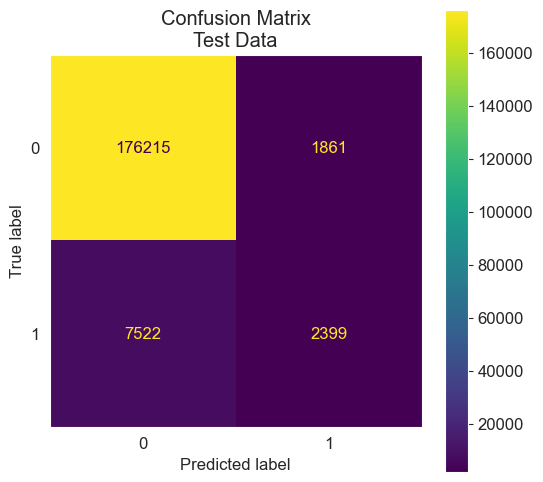

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.96      0.99      0.97    178076
           1       0.56      0.24      0.34      9921

    accuracy                           0.95    187997
   macro avg       0.76      0.62      0.66    187997
weighted avg       0.94      0.95      0.94    187997

Recall Score:
Train: 0.290
Test: 0.242 
False Positive Rate:
Train: 0.008
Test: 0.010 
Accuracy Score:
Train: 0.955
Test: 0.950 
Precision Score:
Train: 0.678
Test: 0.563 
F1 Score:
Train: 0.406
Test: 0.338 
AUC Score:
Train: 0.910
Test: 0.883 


In [661]:
###############
# MODEL FITTING #
###############

# Fit XGBoost Classifier on Imbalanced Data
xgb_imalanced = XGBClassifier(random_state=42)
xgb_imalanced.fit(X_train_scaled, y_train)  # Using the original scaled data

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled,
    X_test_scaled, 
    y_train, 
    y_test, 
    xgb_imalanced
    )

---

### 9.2 XGBoost With Upsampling (scaled, without PCA) <a class="anchor" id="9b"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

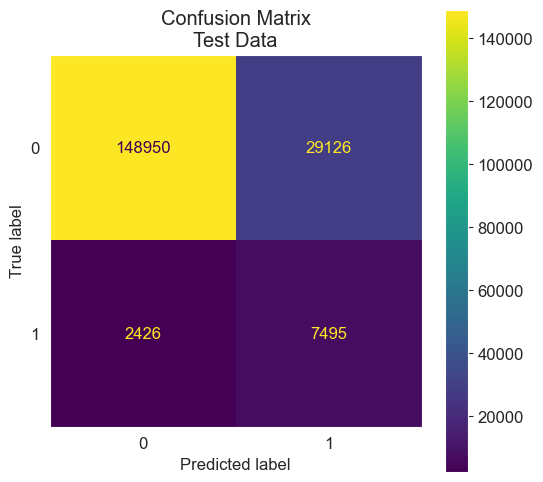

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.90    178076
           1       0.20      0.76      0.32      9921

    accuracy                           0.83    187997
   macro avg       0.59      0.80      0.61    187997
weighted avg       0.94      0.83      0.87    187997

Recall Score:
Train: 0.827
Test: 0.755 
False Positive Rate:
Train: 0.160
Test: 0.164 
Accuracy Score:
Train: 0.834
Test: 0.832 
Precision Score:
Train: 0.838
Test: 0.205 
F1 Score:
Train: 0.833
Test: 0.322 
AUC Score:
Train: 0.918
Test: 0.880 


In [662]:
###############
#MODEL FITTING#
###############

# Upsampled Data
xgb_upsampled = XGBClassifier(random_state=42)
xgb_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_upsampled, 
    X_test_scaled, 
    y_train_upsampled, 
    y_test, 
    xgb_upsampled
)

---

### 9.3 XGBoost With Downsampling (scaled, without PCA) <a class="anchor" id="9c"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

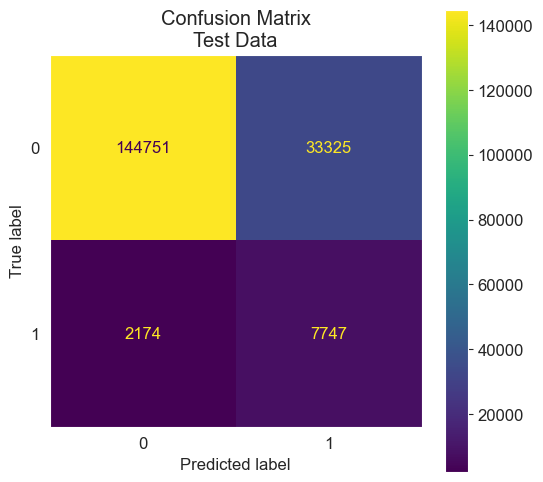

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.99      0.81      0.89    178076
           1       0.19      0.78      0.30      9921

    accuracy                           0.81    187997
   macro avg       0.59      0.80      0.60    187997
weighted avg       0.94      0.81      0.86    187997

Recall Score:
Train: 0.830
Test: 0.781 
False Positive Rate:
Train: 0.137
Test: 0.187 
Accuracy Score:
Train: 0.846
Test: 0.811 
Precision Score:
Train: 0.858
Test: 0.189 
F1 Score:
Train: 0.844
Test: 0.304 
AUC Score:
Train: 0.927
Test: 0.881 


In [663]:
###############
# MODEL FITTING #
###############

# Downsampled Data
xgb_downsampled = XGBClassifier(random_state=42)
xgb_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_downsampled, 
    X_test_scaled, 
    y_train_downsampled, 
    y_test, 
    xgb_downsampled
    )

In [664]:
# Since this is the best performer, store the metrics in the DataFrame
recall_best_model.loc['XGBoost', :] = [
    recall_score(y_train_downsampled, y_pred_train).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_best_model.loc['XGBoost', :] = [
    false_positive_rate(y_train_downsampled, y_pred_train).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---

#### Model Interpretation

The XGBoost model includes a feature importance metric that measures how much each feature contributes to the model's predictions. Features with higher importance scores are considered more impactful within the model. In this section, I will:
1. Find the top 30 features with the highest importance scores.
2. Visualize the most influential features.

In [665]:
# Get feature importances
xgb_importances = xgb_downsampled.feature_importances_

# Create a DataFrame with features and Feature importances
xgb_feature_importance_df = pd.DataFrame(
    xgb_importances.reshape(-1, 1),
    index=X_train.columns,
    columns=['feature_importance']
)

# Sort by the feature importance and show the top five rows
xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='feature_importance', ascending=False)
xgb_feature_importance_df.head(5)

,feature_importance
had_angina,0.356195
difficulty_walking_Yes,0.101106
had_stroke,0.027630
had_diabetes_Yes,0.024103
age_category_80+,0.019622


<Figure size 1500x1500 with 0 Axes>

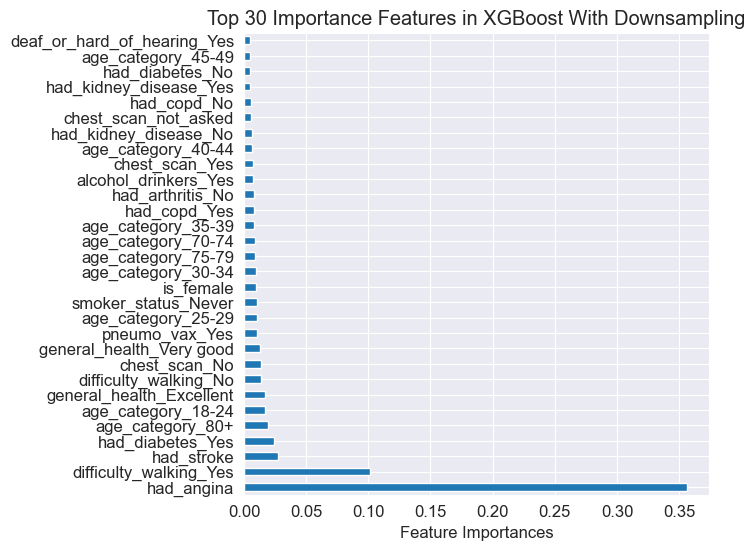

In [666]:
# Visualize the top 40 important features
plt.figure(figsize=(15, 15))
xgb_feature_importance_df.head(30).plot(kind='barh', legend=False)
plt.title('Top 30 Importance Features in XGBoost With Downsampling')
plt.xlabel('Feature Importances')

plt.show()

In [667]:
# Create a list of important features in XGBoost
xgb_important_features = xgb_feature_importance_df.head(30).index.tolist()

xgb_important_features

['had_angina',
 'difficulty_walking_Yes',
 'had_stroke',
 'had_diabetes_Yes',
 'age_category_80+',
 'age_category_18-24',
 'general_health_Excellent',
 'difficulty_walking_No',
 'chest_scan_No',
 'general_health_Very good',
 'pneumo_vax_Yes',
 'age_category_25-29',
 'smoker_status_Never',
 'is_female',
 'age_category_30-34',
 'age_category_75-79',
 'age_category_70-74',
 'age_category_35-39',
 'had_copd_Yes',
 'had_arthritis_No',
 'alcohol_drinkers_Yes',
 'chest_scan_Yes',
 'age_category_40-44',
 'had_kidney_disease_No',
 'chest_scan_not_asked',
 'had_copd_No',
 'had_kidney_disease_Yes',
 'had_diabetes_No',
 'age_category_45-49',
 'deaf_or_hard_of_hearing_Yes']

**Takeaways**:
- Compared to the Random Forest model, fewer features contributed to the prediction of the target variable in the XGBoost model. Similarly, `had_angina` has the highest predicive power with the dominant importance value. The remaining features among the top 20 important features appear to have relatively little predictive power for the target variable.

---

### 9.4 Best Model with PCA - XGBoost With Downsampling and PCA <a class="anchor" id="9d"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

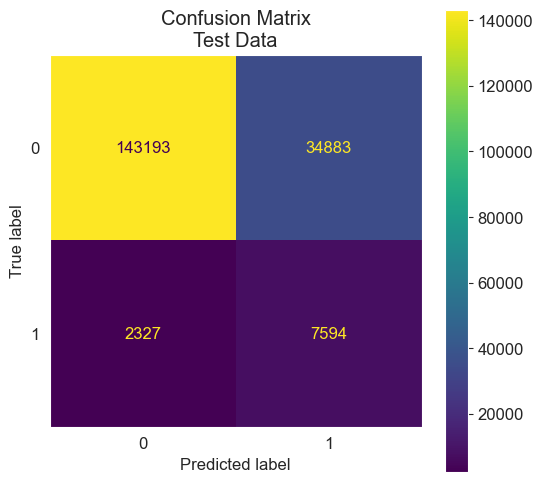

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.80      0.89    178076
           1       0.18      0.77      0.29      9921

    accuracy                           0.80    187997
   macro avg       0.58      0.78      0.59    187997
weighted avg       0.94      0.80      0.85    187997

Recall Score:
Train: 0.876
Test: 0.765 
False Positive Rate:
Train: 0.083
Test: 0.196 
Accuracy Score:
Train: 0.897
Test: 0.802 
Precision Score:
Train: 0.913
Test: 0.179 
F1 Score:
Train: 0.894
Test: 0.290 
AUC Score:
Train: 0.960
Test: 0.870 


In [668]:
###############
# MODEL FITTING #
###############

# Downsampled Data with PCA
xgb_downsampled_pca = XGBClassifier(random_state=42)
xgb_downsampled_pca.fit(X_train_pca_downsampled, y_train_downsampled)

##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_pca_downsampled, 
    X_test_pca_downsampled, 
    y_train_downsampled, 
    y_test, 
    xgb_downsampled_pca
    )

---

### 9.5 XGBoost Baseline Modeling Summary <a class="anchor" id="9e"></a>

**Metrics using test data:**<br>

| Model                   | PCA | Recall | FPR  | Accuracy | Precision | F1 Score | AUC   | Notes                       |
|-------------------------|-----|--------|------|----------|-----------|----------|-------|-----------------------------|
| XGBoost                 | No  | 0.242  | 0.010| 0.950    | 0.563     | 0.338   | 0.883 | Imbalanced                  |
| XGBoost                 | No  | 0.755  | 0.164| 0.832    | 0.205     | 0.322    | 0.880 | Upsampled     |
| **XGBoost**             | No  | **0.781**  | **0.187**| 0.811    | 0.189     | 0.304    | 0.881 | **Downsampled** |
| XGBoost             | Yes  | 0.765  | 0.196| 0.802    | 0.179     | 0.290    | 0.870 | Downsampled with PCA, overfitting|

- So far, hyperparameter tuning has not been conducted on any of the XGBoost models. Due to the tendency of Decision Trees to overfit the data, I have set the maximum depth to 7 across all baseline models. 
- The XGBoost with downsampling achieves the highest recall score, although its false positive rate is slightly higher than that of the upsampled models. Given that a false positive rate of 18.7% is considered acceptable, I will select this model as the best performer.
- XGBoost with PCA shows signs of overfitting, as evidenced by significantly lower accuracy and recall metrics on the test data compared to the training data.
- In the model interpretation of XGBoost Model With Downsampling model, about 20 out of 149 features were found to significantly contribute to predicting the target. A vast number of unimportant features could potentially lead to overfitting, so reducing the feature could help improve generalization.


---

## 10 Baseline Modeling - Neural Network <a class="anchor" id="10"></a>

Training neural networks can be highly computationally intensive. Therefore, I will train the baseline model using downsampled data to achieve faster training times. I've previously experimented with training on both imbalanced and upsampled data, but I had to terminate those attempts due to the following reasons:

1. The recall score on the imbalanced data was very low, with no notable improvement after several epochs.
2. The recall and false positive metrics for the upsampled training data were similar to those obtained from the downsampled data, but the training time per epoch was significantly longer.

---

### 10.1 Neural Network With Downsampled Data  <a class="anchor" id="10a"></a>

In [ ]:
# Set up the structure 
nn_model = Sequential([
    Dense(10, activation="relu"),   # Add hidden layer
    Dense(10, activation="relu"),   # Add hidden layer
    Dense(10, activation="relu"),   # Add hidden layer
    Dense(1, activation='sigmoid')  # Output layer
])


# Compile the model
nn_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        'accuracy',   # Monitor accuracy
        keras.metrics.Recall(name='recall'),      # Monitoring recall
        keras.metrics.FalsePositives(name='fp')  # Monitoring false positives
    ]
)


# Create early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [786]:
# Fit the model
history = nn_model.fit(
    X_train_scaled_downsampled,
    y_train_downsampled,
    epochs=100,
    batch_size=10,
    verbose=1,
    validation_data=(X_test_scaled, y_test), 
    callbacks=[early_stopping]  # Set up early stopping to prevent overfitting
)

Epoch 1/100
5953/5953 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.7482 - fp: 3242.9099 - loss: 0.4959 - recall: 0.7226 - val_accuracy: 0.7955 - val_fp: 36431.0000 - val_loss: 0.4238 - val_recall: 0.7970
Epoch 2/100
5953/5953 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8022 - fp: 2908.4358 - loss: 0.4225 - recall: 0.8001 - val_accuracy: 0.7963 - val_fp: 36297.0000 - val_loss: 0.4291 - val_recall: 0.7993
Epoch 3/100
5953/5953 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.8082 - fp: 2839.8022 - loss: 0.4145 - recall: 0.8053 - val_accuracy: 0.8083 - val_fp: 33894.0000 - val_loss: 0.4116 - val_recall: 0.7836
Epoch 4/100
5953/5953 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8067 - fp: 2832.1655 - loss: 0.4148 - recall: 0.8042 - val_accuracy: 0.8017 - val_fp: 35221.0000 - val_loss: 0.4252 - val_recall: 0.7923
Epoch 5/100
5953/5953 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8101 - fp: 2819.7881 - loss: 0.4113 - recall: 0.8076 - val_accuracy: 0.7966 - val_fp: 36220.0000 - val

1861/1861 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
5875/5875 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Confusion matrices: 


<Figure size 300x300 with 0 Axes>

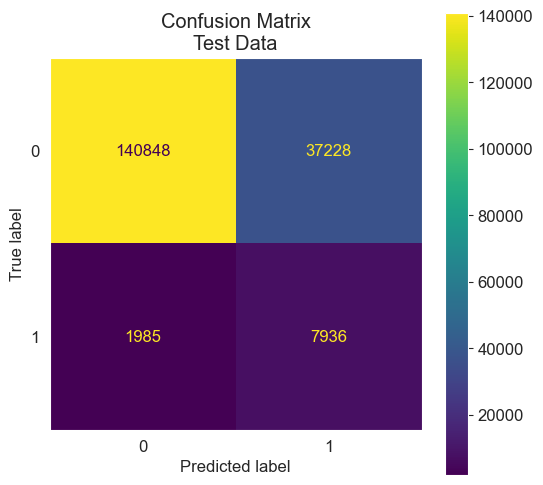

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.99      0.79      0.88    178076
           1       0.18      0.80      0.29      9921

    accuracy                           0.79    187997
   macro avg       0.58      0.80      0.58    187997
weighted avg       0.94      0.79      0.85    187997

Recall Score:
Train: 0.824
Test: 0.800 
False Positive Rate:
Train: 0.190
Test: 0.209 
Accuracy Score:
Train: 0.817
Test: 0.791 
Precision Score:
Train: 0.812
Test: 0.176 
F1 Score:
Train: 0.818
Test: 0.288 
AUC Score:
Train: 0.898
Test: 0.882 


In [855]:
##################
#MODEL EVALUATION#
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_downsampled, 
    X_test_scaled, 
    y_train_downsampled, 
    y_test, 
    nn_model,
    is_neural_network=True
    )

In [856]:
# Store the metrics in the DataFrame
recall_best_model.loc['Neural Network', :] = [
    recall_score(y_train_downsampled, y_pred_train).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_best_model.loc['Neural Network', :] = [
    false_positive_rate(y_train_downsampled, y_pred_train).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

### 10.2 Neural Network Baseline Modeling Summary <a class="anchor" id="10b"></a>

**Metrics using test data:**
| Model                   | PCA | Recall | FPR  | Accuracy | Precision | F1 Score | AUC   | Notes                                             |
|-------------------------|-----|--------|------|----------|-----------|----------|-------|---------------------------------------------------|
| Neural Network     | No  |0.800 | 0.209 | 0.791    |0.176     | 0.288   | 0.882 | Downsampled                                       |

- The metrics of the neural network are comparable to those obtained using XGBoost with the same downsampled training data.
- In the baseline neural network, I used a relatively simple structure with three fully connected hidden layers, each containing 10 neurons.
- I used keras.losses.BinaryCrossentropy() as the loss function, and I plan to create a customized loss function to optimize for recall and false positive rate, aligning the loss optimization with the metrics of success.


---




## 11. Baseline Model Evaluation <a class="anchor" id="11"></a>

### 11.1 Important/Predictive Features in Various Baseline Models <a class="anchor" id="11a"></a>

- During the baseline modeling stage, I identified the important or predictive features in Logistic Regression, Decision Tree, Random Forest, and XGBoost.
- In this section, I will combine all these important features to determine the total number of unique important features and count how many times each feature has occurred across the four models.

([<matplotlib.axis.XTick at 0x1a879dd88d0>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4')])

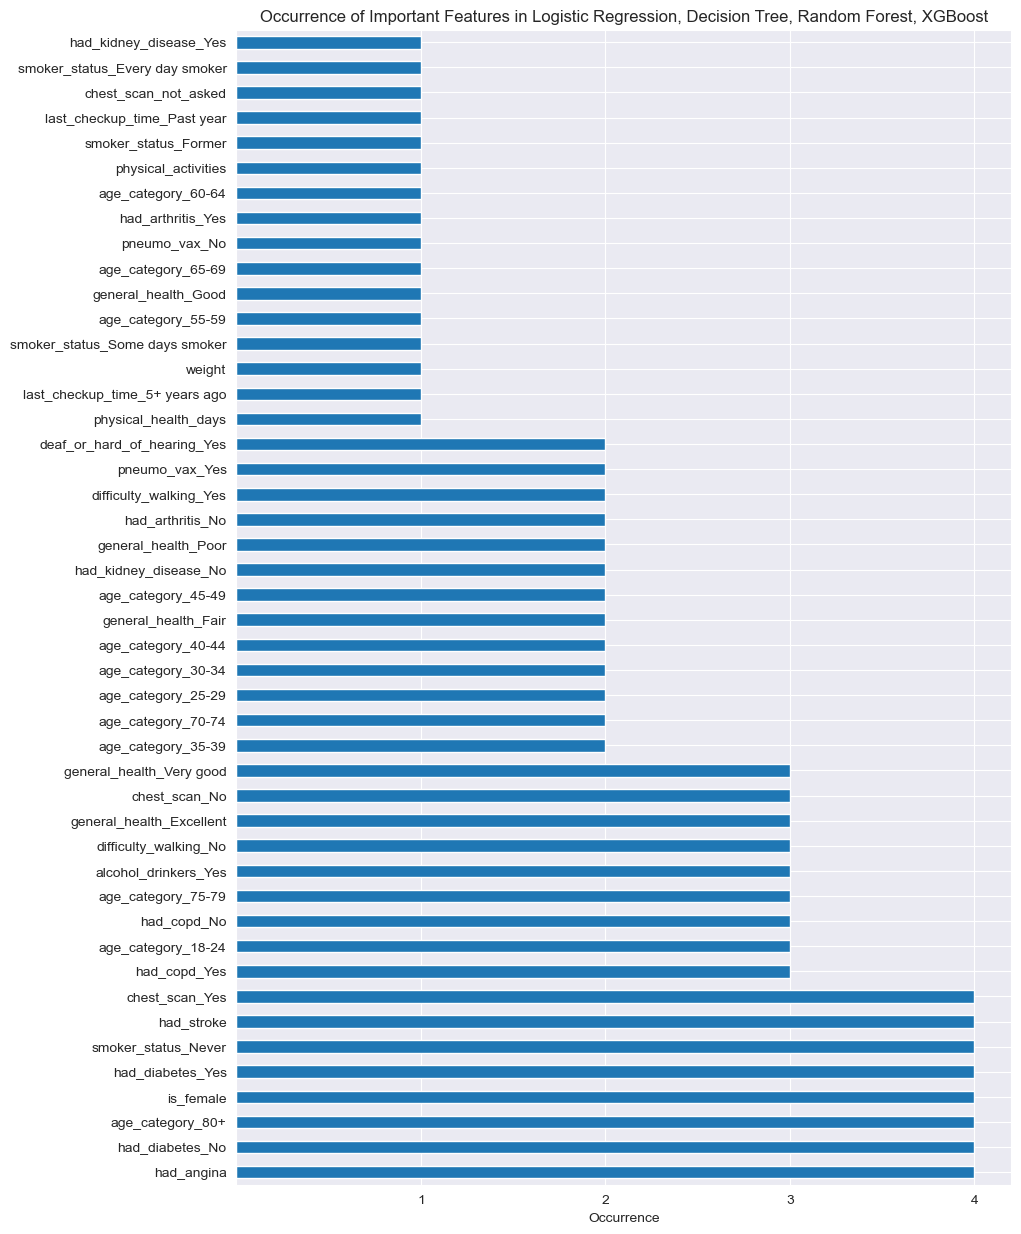

In [191]:
# Create a list of all important features
all_important_features = (
    logreg_important_features + 
    dt_important_features + 
    rf_important_features + 
    xgb_important_features
)

# Create a DataFrame of all important features
important_features_df = pd.DataFrame(all_important_features, columns=['Feature'])

# Count the appearance of important features in these four models
important_features_occurance = important_features_df['Feature'].value_counts()\
    .sort_values(ascending=False)

# Visualize 
plt.figure(figsize=(10, 15))
important_features_occurance.plot(kind='barh')
plt.title('Occurrence of Important Features in Logistic Regression, Decision Tree, Random Forest, XGBoost')
plt.xlabel('Occurrence')
plt.ylabel('')
plt.xticks(range(1, 5))

In [192]:
# Print the total number of features
print(f'Total number of features in baseline modeling: {X_train_encoded.shape[1]}')

# Print the number of all important features
print(f'Number of all important features: {len(important_features_occurance)}')

Total number of features in baseline modeling: 175
Number of all important features: 46


**Takeaways**:
- Despite aggregating all important features from four of the five classification models, fewer than 30% of the features are actually significant or predictive for the target variable, while the remaining 70% are considered unimportant. This significant number of excessive features poses a potential risk for overfitting in these models. Therefore, feature reduction and refinement should be conducted in the next stage to enhance model performance.

---

### 10.2 Model Comparison and Summary <a class="anchor" id="11b"></a>

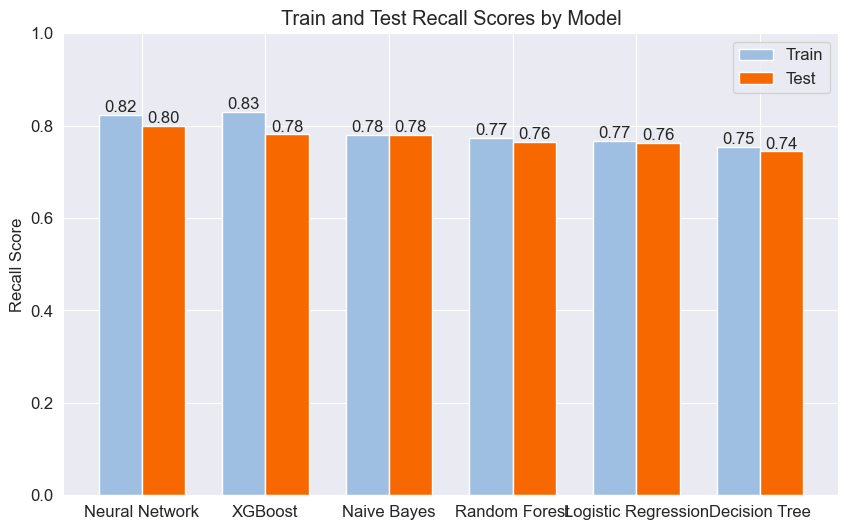

In [790]:
# Sort the DataFrame by test score
recall_best_model = recall_best_model.sort_values(by='Test', ascending=False)

# Plot the recall metrics of best performer within each classification model
plt.figure(figsize=(10, 6))

# Set up bar width and list of number of models 
bar_width = 0.35
x = range(len(recall_best_model))

# Plot train bars
train_bars = plt.bar(x, 
                     recall_best_model['Train'], 
                     width=bar_width, 
                     label='Train', 
                     color='#9EBFE2')

# Plot test bars next to train bars
test_bars = plt.bar([i + bar_width for i in x], 
                    recall_best_model['Test'], 
                    width=bar_width, label='Test', 
                    color='#F76900')

# Annotate bars with recall scores
for bar in train_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom')

for bar in test_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom')


plt.xticks([i + bar_width / 2 for i in x], recall_best_model.index)  # Set x-ticks to be centered
plt.title('Train and Test Recall Scores by Model')
plt.ylabel('Recall Score')
plt.legend()
plt.ylim(0.0, 1.0)

plt.show()

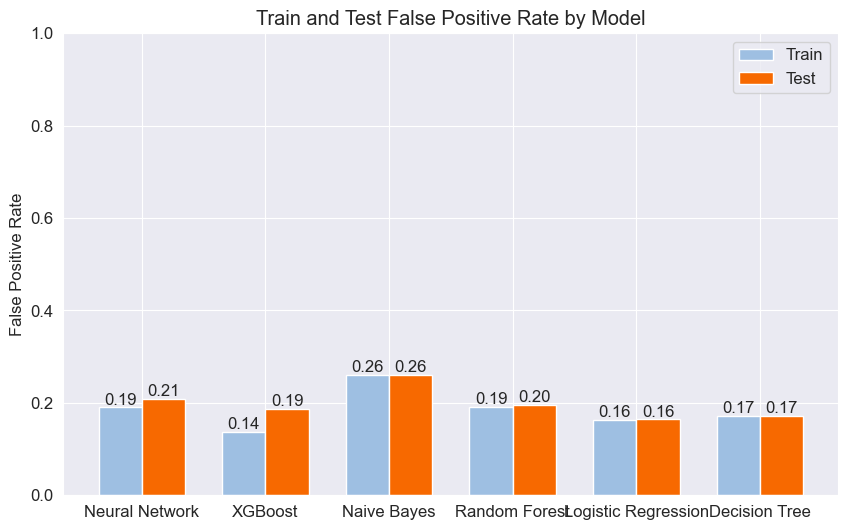

In [791]:
# Sort the DataFrame to align with the order in false positive score
fpr_best_model = fpr_best_model.loc[
    ['Neural Network', 'XGBoost', 'Naive Bayes' ,'Random Forest', 'Logistic Regression','Decision Tree',]
    ]

# Plot the fpr metrics of best performer within each classification model
plt.figure(figsize=(10, 6))

# Set up bar width and list of number of models 
bar_width = 0.35
x = range(len(fpr_best_model))

# Plot train bars
train_bars = plt.bar(x, 
                     fpr_best_model['Train'], 
                     width=bar_width, 
                     label='Train', 
                     color='#9EBFE2')

# Plot test bars next to train bars
test_bars = plt.bar([i + bar_width for i in x], 
                    fpr_best_model['Test'], 
                    width=bar_width, label='Test', 
                    color='#F76900')

# Annotate bars with false positive rate 
for bar in train_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom')

for bar in test_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom')


plt.xticks([i + bar_width / 2 for i in x], fpr_best_model.index)  # Set x-ticks to be centered
plt.title('Train and Test False Positive Rate by Model')
plt.ylabel('False Positive Rate')
plt.legend()
plt.ylim(0.0, 1.0)

plt.show()

**Metrics Comparison Across Different Models (using test data):**<br>
random_state=42 is applied to all models that  incorporate randomness.

| Model                   | X_train     | Hyperparameters                      | PCA | Recall | FPR  | Accuracy | Precision | F1 Score | AUC   | Notes                       |
|-------------------------|-------------|--------------------------------------|-----|--------|------|----------|-----------|----------|-------|-----------------------------|
| Logistic Regression      | Upsampled   | max_iter=1000                       | No  |  0.763  |0.164 | 0.832    | 0.206     | 0.325    | 0.885  |                  |
| Naive Bayes             | Upsampled |                                      | No  |  0.780  | 0.260| 0.742    | 0.143     | 0.242    | 0.822 |                  |
| Decision Tree           | Upsampled | max_depth=7                         | No  |  0.744  | 0.171| 0.824    | 0.195     | 0.309    | 0.856 |                |
| Random Forest           | Upsampled   | n_estimators=50, max_depth=7       | No  | 0.766  | 0.188| 0.809    | 0.185     | 0.298   | 0.871 |                  |
| XGBoost             | Downsampled |                                  | No | 0.781  | 0.187| 0.811    | 0.189     | 0.304    | 0.881 |      slightly overfitting       |
| **Neural Network**         | **Downsampled**   | 3 hidden layers, 10 neurons in each layer       | No  | **0.800** | **0.209** | 0.791    |0.176     | 0.288   | 0.882|  


**Summary:**
1. Up to this stage, I have evaluated several baseline models, including Logistic Regression, Naive Bayes, Decision Tree, Random Forest, and XGBoost. For each model, I trained on both imbalanced data and balanced data using upsampling and downsampling techniques. The table below presents the best performer for each model based on performance metrics. 
2. To reiterate the success metrics introduced in the beginning of this notebook, model performance will primarily be assessed using recall and the false positive rate (FPR). The objective is to prioritize achieving a high recall up to 0.8-0.9 while maintaining the FPR under a reasonable level.
3. Among the baseline models, XGBoost and Neural Network demonstrated similaraly top performance in recall. However, since the XGBoost exhibit signs of overfitting, and **Neural Network** has the highest recall, it is selected as the **best performer**.
4. I used keras.losses.BinaryCrossentropy() as the loss function, and I plan to create a customized loss function to optimize for recall and false positive rate, aligning the loss optimization with the metrics of success.
5. No hyperparameter tuning was conducted during the baseline modeling phase; most hyperparameters were chosen based on intuition to help prevent overfitting and establish a fixed random seed.
6. All models employing upsampling and downsampling techniques to achieve balanced classes in the training data exhibit a significant gap in precision scores between the training and test datasets. This discrepancy may be attributed to overfitting, especially given that the baseline models consist of 149 features. Additionally, the imbalanced distribution in the test set plays a critical role. Recall the formula for precision:
 $\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}$.
In the test set, where negatives comprise 94.7% of the data, even a small false positive rate can lead to a substantial number of false positives. This increase in false positives ultimately reduces the precision score, contributing to the observed discrepancy between training and test precision.
7. I applied PCA to the best-performing models—Logistic Regression and XGBoost—to determine whether dimensionality reduction could mitigate overfitting or enhance model performance. However, both models did not demonstrate improved performance on the test data.  During my analysis on reducing dimensionality with PCA, I discovered that it was not well-suited for the current combinantion of features, as it required over 110 principal components to achieve a total explained variance ratio of 90%.
8. As noted previously, over 67% of the features are considered unimportant, which contributes to the risk of overfitting. In the next phase, I will revisit feature engineering to identify and retain the most critical features while filtering out the less relevant ones. I will then assess if these changes can improve model performance. Following this, I will re-evaluate the models to determine if overfitting can be mitigated.

---



### 11.3 In-Depth Analysis of Top Performing Baseline Models <a class="anchor" id="11c"></a>

In this section, I will provide an in-depth analysis of the best-performing models: XGBoost and the Neural Network.

Calculate the AUC and get ROC for XGBoost and Neural Network

In [792]:
# Get the probabilistic predition 
y_proba_train_xgb  = xgb_downsampled.predict_proba(X_train_scaled_downsampled)[:, 1]
y_proba_test_xgb = xgb_downsampled.predict_proba(X_test_scaled)[:, 1]

y_proba_train_nn  = nn_model.predict(X_train_scaled_downsampled)
y_proba_test_nn = nn_model.predict(X_test_scaled)

# Create a thresholds from 0 to 1 with each step 0f 0.01
thresholds = np.linspace(0, 1, 50)

# Create TPR and FPR lists to store the value of these metrics with corresponding threshold
xgb_tpr_train_list = []
xgb_fpr_train_list = []
xgb_tpr_test_list = []
xgb_fpr_test_list = []

nn_tpr_train_list = []
nn_fpr_train_list = []
nn_tpr_test_list = []
nn_fpr_test_list = []


for threshold in thresholds: 
    # Use threshold to get the hard prediction
    y_pred_train_xgb = np.where(y_proba_train_xgb > threshold, 1, 0).flatten()
    y_pred_test_xgb = np.where(y_proba_test_xgb > threshold, 1, 0).flatten()

    y_pred_train_nn = np.where(y_proba_train_nn > threshold, 1, 0).flatten()
    y_pred_test_nn = np.where(y_proba_test_nn > threshold, 1, 0).flatten()

    # Caltulate TPR and FPR
    xgb_tpr_train = recall_score(y_train_downsampled, y_pred_train_xgb)
    xgb_fpr_train = false_positive_rate(y_train_downsampled, y_pred_train_xgb)
    xgb_tpr_test = recall_score(y_test, y_pred_test_xgb)
    xgb_fpr_test = false_positive_rate(y_test, y_pred_test_xgb)

    nn_tpr_train = recall_score(y_train_downsampled, y_pred_train_nn)
    nn_fpr_train = false_positive_rate(y_train_downsampled, y_pred_train_nn)
    nn_tpr_test = recall_score(y_test, y_pred_test_nn)
    nn_fpr_test = false_positive_rate(y_test, y_pred_test_nn)

    # Append tpr and fpr to the list
    xgb_tpr_train_list.append(xgb_tpr_train)
    xgb_fpr_train_list.append(xgb_fpr_train)
    xgb_tpr_test_list.append(xgb_tpr_test)
    xgb_fpr_test_list.append(xgb_fpr_test)

    nn_tpr_train_list.append(nn_tpr_train)
    nn_fpr_train_list.append(nn_fpr_train)
    nn_tpr_test_list.append(nn_tpr_test)
    nn_fpr_test_list.append(nn_fpr_test)


# Get (AUC)
auc_train_xgb = np.round(roc_auc_score(y_train_downsampled, y_proba_train_xgb), 3)
auc_test_xgb = np.round(roc_auc_score(y_test, y_proba_test_xgb), 3)

auc_train_nn = np.round(roc_auc_score(y_train_downsampled, y_proba_train_nn), 3)
auc_test_nn = np.round(roc_auc_score(y_test, y_proba_test_nn), 3)

# Create Labels
train_label_xgb = f'Train Logit AUC: {auc_train_xgb}'
test_label_xgb = f'Test Logit AUC: {auc_test_xgb}'

train_label_nn = f'Train Logit AUC: {auc_train_nn}'
test_label_nn = f'Test Logit AUC: {auc_test_nn}'

1861/1861 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
5875/5875 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


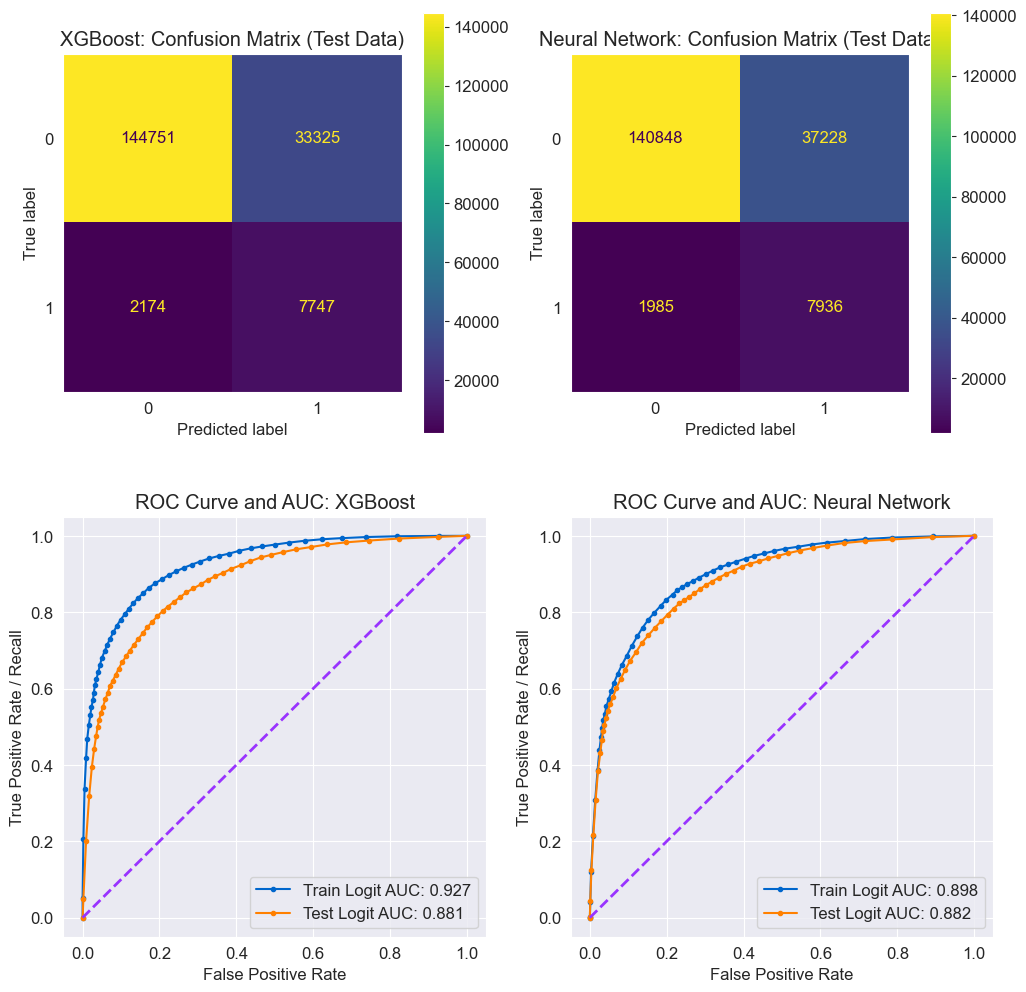

In [793]:
# Instantiate a 2 x 2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot the confusion matrix of XGBoost
y_pred_test_xgb = np.where(y_proba_test_xgb > 0.5, 1, 0).flatten()
conf_matrix_xgb = confusion_matrix(y_test, y_pred_test_xgb)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb).plot(ax=axes[0, 0])
axes[0, 0].set_title('XGBoost: Confusion Matrix (Test Data)')
axes[0, 0].grid(False) 

# Plot the confusion matrix of Neural Network
y_pred_test_nn = np.where(y_proba_test_nn > 0.5, 1, 0).flatten()
conf_matrix_nn = confusion_matrix(y_test, y_pred_test_nn)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_nn).plot(ax=axes[0, 1])
axes[0, 1].set_title('Neural Network: Confusion Matrix (Test Data)')
axes[0, 1].grid(False) 

# Plot the ROC curve of XGBoost
axes[1, 0].plot(xgb_fpr_train_list, xgb_tpr_train_list, marker='.', label=train_label_xgb, c='#0066CC') # Create ROC Curve for train sets
axes[1, 0].plot(xgb_fpr_test_list, xgb_tpr_test_list, marker='.', label=test_label_xgb, c='#FF8000') # Create ROC Curve for test sets
axes[1, 0].plot([0, 1], [0, 1], lw=2, linestyle="--", c='#9933FF') # Create uninformative classifier
axes[1, 0].set_title('ROC Curve and AUC: XGBoost')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate / Recall')
axes[1, 0].legend() 

# Plot the ROC curve of Neural Network
axes[1, 1].plot(nn_fpr_train_list, nn_tpr_train_list, marker='.', label=train_label_nn, c='#0066CC') # Create ROC Curve for train sets
axes[1, 1].plot(nn_fpr_test_list, nn_tpr_test_list, marker='.', label=test_label_nn, c='#FF8000') # Create ROC Curve for test sets
axes[1, 1].plot([0, 1], [0, 1], lw=2, linestyle="--", c='#9933FF') # Create uninformative classifier
axes[1, 1].set_title('ROC Curve and AUC: Neural Network')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate / Recall')
axes[1, 1].legend() 

plt.show()


**Takeaways:**
1. By comparing the two confusion matrices, Neural Network model did a better job in identifying true positives with a sacrifice in higher false positive rate.
2. By comparing the ROC curves, I observed that overfitting is more pronounced in XGBoost, as evidenced by the  gap between the train and test ROC curve. This overfitting suggests that XGBoost has a higher variance, making it more likely to underperform with unseen data. Therefore, Neural Network is the more preferred model.
3. Tuning the threshold could help achieve a higher recall with an acceptable sacrifice of increase in false positive rate. Both models are able to achieve a recall above 80% with fpr slightly over 20%.


---

## 12. Advanced Feature Selection <a class="anchor" id="12"></a>

### 12.1 Feature Selection  <a class="anchor" id="12a"></a>

Analysis of baseline models revealed less than 30% of features (after one-hot-encoding) significantly contribute to predicting the target. To mitigate overfitting risks and enhance model generalizability, I will perform feature selection to identify the optimal subset of predictors.

Update the selected features

In [874]:
# Pick important features
selected_features = ['is_female', 'race_ethnicity_category', 'age_category', 'bmi_category', 'alcohol_drinkers',
       'general_health', 'smoker_status', 'physical_activities', 'had_angina', 'had_stroke', 'had_copd', 
       'had_diabetes', 'had_kidney_disease','had_depressive_disorder', 'had_arthritis', 'deaf_or_hard_of_hearing',
       'blind_or_vision_difficulty', 'difficulty_walking', 'difficulty_dressing_bathing']

In [875]:
# Check unselected features
unselected_features = [col for col in X.columns if col not in selected_features]

# Print unselected features
print(f'Features that are excluded: ')
for feature in unselected_features:
    print(feature)

Features that are excluded: 
year
state
height
weight
bmi
e_cigarette_usage
physical_health_days
mental_health_days
stress_levels
had_asthma
had_skin_cancer
difficulty_concentrating
difficulty_errands
last_checkup_time
chest_scan
flu_vax
tetanus_vax
pneumo_vax


In [876]:
# Creata X_selected with important features
X_selected = X[selected_features].copy()

In [877]:
# Train-test split for x and y
X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(X_selected, y, stratify=y, test_size=0.25, random_state=1)

# Check shape of X_train_updated and X_test_updated
print(f'X_train_updated shape: {X_train_updated.shape}')
print(f'X_test_updated shape: {X_test_updated.shape}')

X_train_updated shape: (563988, 19)
X_test_updated shape: (187997, 19)


- One hot encoding

Fit transform X_train

In [878]:
# Get the categorical and numeric columns
updated_categorical_columns = X_train_updated.select_dtypes(include='object').columns.tolist()
updated_numeric_columns = X_train_updated.select_dtypes(include='number').columns.tolist()

# Instantiate the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit transform the X_train_updated categorical variables to array
encoded_array_train = encoder.fit_transform(X_train_updated[updated_categorical_columns])

# Convert from array to DataFrame
encoded_df_train_updated = pd.DataFrame(
    encoded_array_train, 
    columns=encoder.get_feature_names_out(updated_categorical_columns),
    index=X_train_updated.index
)

# Concatenate with encoded df
X_train_updated_encoded = pd.concat([X_train_updated[updated_numeric_columns], encoded_df_train_updated], axis=1)


Transform X_test

In [879]:
# Transform X_test_updated
encoded_array_test = encoder.transform(X_test_updated[updated_categorical_columns])

# Convert array into DataFrame
encoded_df_test_updated = pd.DataFrame(
    encoded_array_test, 
    columns=encoder.get_feature_names_out(updated_categorical_columns),
    index=X_test.index
    )

# Concatenate encoded_df_test with X_test_updated numeric columns
X_test_updated_encoded = pd.concat([X_test_updated[updated_numeric_columns], encoded_df_test_updated], axis=1)

In [880]:
# Set X_train and X_test equal to encoded DataFrames
X_train_updated = X_train_updated_encoded
X_test_updated = X_test_updated_encoded

# Print shape
print(f"Shape of X_train_updated:{X_train_updated.shape}")
print(f"Shape of X_test_updated:{X_test_updated.shape}")

Shape of X_train_updated:(563988, 70)
Shape of X_test_updated:(187997, 70)


The number of features after one hot encoding has dropped significantly.

---

- Feature Scaling

In [882]:
# Instantiate StandardScaler
scaler_updated = StandardScaler()

# Fit the scaler_updated
scaler_updated.fit(X_train_updated)


# Transform X_train_updated  X_test_updated
X_train_scaled_updated = scaler_updated.transform(X_train_updated)
X_test_scaled_updated = scaler_updated.transform(X_test_updated)

---

Resampling to achieve a balanced train dataset.

- Upsampling

In [883]:
# Randomly duplicate class 1 observations
X_duplicate_positive, y_duplicate_positive = resample(
    X_train_scaled_updated[y_train_updated == 1],
    y_train_updated[y_train_updated == 1],
    replace=True,
    n_samples=X_train_scaled_updated[y_train_updated == 0].shape[0],
    random_state=1
)

# Combine upsample with original data
X_train_scaled_upsampled_updated = pd.DataFrame(
    np.vstack((X_train_scaled_updated[y_train_updated == 0], X_duplicate_positive)),
    columns=X_train_updated.columns
)

y_train_upsampled_updated = np.hstack((y_train_updated[y_train_updated == 0], y_duplicate_positive))

# Print the number of classes after upsampling
print(f"\nNumber of Class 1 samples after upsampling: {y_train_upsampled_updated.sum()}")
print(f"Number of Class 0 samples after upsampling: {y_train_upsampled_updated.shape[0] - y_train_upsampled_updated.sum()}")


Number of Class 1 samples after upsampling: 534226
Number of Class 0 samples after upsampling: 534226


- Downsampling

In [884]:
# Randomly remove negative class 0 observations
X_remove_negative, y_remove_negative = resample(
    X_train_scaled_updated[y_train_updated == 0],
    y_train_updated[y_train_updated == 0],
    replace=False,
    n_samples=X_train_scaled_updated[y_train_updated == 1].shape[0],
    random_state=1
)

# Combine downsampled data with original dataset
X_train_scaled_downsampled_updated = pd.DataFrame(
    np.vstack((X_train_scaled_updated[y_train_updated == 1], X_remove_negative)), 
    columns=X_train_updated.columns
)

y_train_downsampled_updated = np.hstack((y_train_updated[y_train_updated == 1], y_remove_negative))

# Print the number of classes after downsampling
print(f'Number of Class 0 samples after downsampling: {y_train_downsampled_updated[y_train_downsampled_updated == 0].shape[0]}')
print(f'Number of Class 1 samples after downsampling: {y_train_downsampled_updated.sum()}')


Number of Class 0 samples after downsampling: 29762
Number of Class 1 samples after downsampling: 29762


---

In [724]:
# Create two DataFrames to store the new metrics of each classification model after feature selection
recall_new_model = pd.DataFrame(
    index=['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost', 'Neural Network'],
    columns=['Train', 'Test']
    )

fpr_new_model = pd.DataFrame(
    index=['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost', 'Neural Network'],
    columns=['Train', 'Test']
)

---

### 12.2 Retrain Baseline Models  <a class="anchor" id="12b"></a>

Train the best performer within each baseline model class using the updated features, and compare results.

- Logistic Regression with upsampling

Confusion matrices: 


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<Figure size 300x300 with 0 Axes>

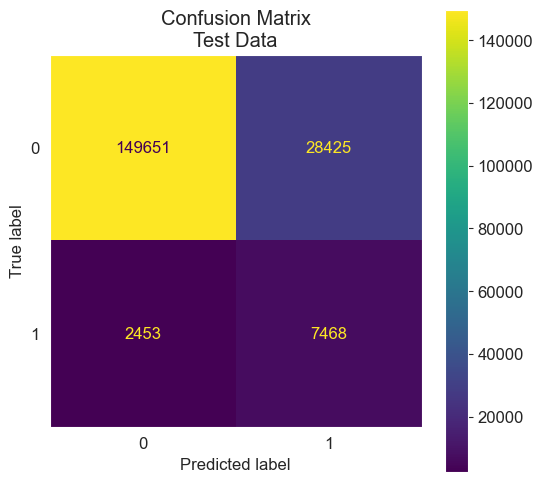

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.91    178076
           1       0.21      0.75      0.33      9921

    accuracy                           0.84    187997
   macro avg       0.60      0.80      0.62    187997
weighted avg       0.94      0.84      0.88    187997

Recall Score:
Train: 0.757
Test: 0.753 
False Positive Rate:
Train: 0.159
Test: 0.160 
Accuracy Score:
Train: 0.799
Test: 0.836 
Precision Score:
Train: 0.827
Test: 0.208 
F1 Score:
Train: 0.790
Test: 0.326 
AUC Score:
Train: 0.884
Test: 0.882 


In [885]:
###############
# MODEL FITTING #
###############

# Upsampled Data
logit_upsampled_updated = LogisticRegression(max_iter=1000, random_state=42)
logit_upsampled_updated.fit(X_train_scaled_upsampled_updated, y_train_upsampled_updated)

##################
# MODEL EVALUATION #
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_upsampled_updated, 
    X_test_scaled_updated,  
    y_train_upsampled_updated, 
    y_test_updated,  
    logit_upsampled_updated
)

In [726]:
#  Store the metrics in the DataFrame
recall_new_model.loc['Logistic Regression', :] = [
    recall_score(y_train_upsampled, y_pred_train).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_new_model.loc['Logistic Regression', :] = [
    false_positive_rate(y_train_upsampled, y_pred_train).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---

- Naive Bayes with upsampling

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


Confusion matrices: 


<Figure size 300x300 with 0 Axes>

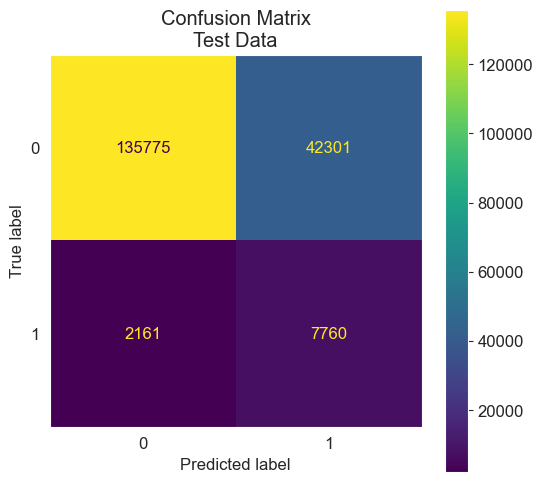

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.76      0.86    178076
           1       0.16      0.78      0.26      9921

    accuracy                           0.76    187997
   macro avg       0.57      0.77      0.56    187997
weighted avg       0.94      0.76      0.83    187997

Recall Score:
Train: 0.782
Test: 0.782 
False Positive Rate:
Train: 0.236
Test: 0.238 
Accuracy Score:
Train: 0.773
Test: 0.763 
Precision Score:
Train: 0.768
Test: 0.155 
F1 Score:
Train: 0.775
Test: 0.259 
AUC Score:
Train: 0.838
Test: 0.836 


In [886]:
###############
# MODEL FITTING #
###############

# Upsampled Data
nbmodel_upsampled_updated = GaussianNB()
nbmodel_upsampled_updated.fit(X_train_scaled_upsampled_updated, y_train_upsampled_updated)

##################
# MODEL EVALUATION #
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_upsampled_updated, 
    X_test_scaled_updated,  
    y_train_upsampled_updated, 
    y_test_updated, 
    nbmodel_upsampled_updated
)

In [728]:
# Store the metrics in the DataFrame
recall_new_model.loc['Naive Bayes', :] = [
    recall_score(y_train_upsampled, y_pred_train).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_new_model.loc['Naive Bayes', :] = [
    false_positive_rate(y_train_upsampled, y_pred_train).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---

- Decision Tree with upsampling

Confusion matrices: 


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Figure size 300x300 with 0 Axes>

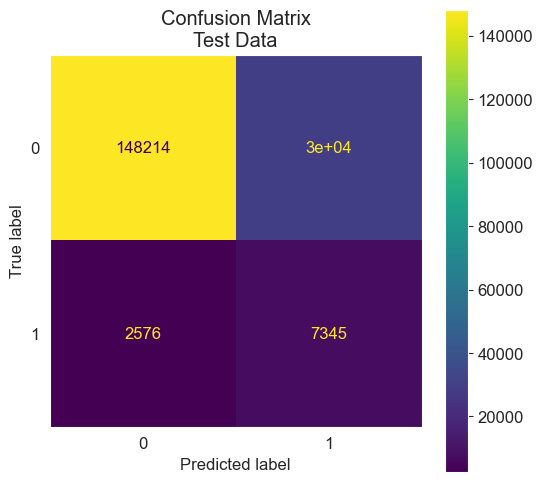

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.83      0.90    178076
           1       0.20      0.74      0.31      9921

    accuracy                           0.83    187997
   macro avg       0.59      0.79      0.61    187997
weighted avg       0.94      0.83      0.87    187997

Recall Score:
Train: 0.749
Test: 0.740 
False Positive Rate:
Train: 0.168
Test: 0.168 
Accuracy Score:
Train: 0.791
Test: 0.827 
Precision Score:
Train: 0.817
Test: 0.197 
F1 Score:
Train: 0.781
Test: 0.312 
AUC Score:
Train: 0.861
Test: 0.856 


In [887]:
###############
# MODEL FITTING #
###############

# Upsampled Data
dt_upsampled_updated = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_upsampled_updated.fit(X_train_scaled_upsampled_updated, y_train_upsampled_updated)

##################
# MODEL EVALUATION #
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_upsampled_updated, 
    X_test_scaled_updated,  
    y_train_upsampled_updated, 
    y_test_updated,  
    dt_upsampled_updated
)

In [730]:
# Store the metrics in the DataFrame
recall_new_model.loc['Decision Tree', :] = [
    recall_score(y_train_upsampled, y_pred_train).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_new_model.loc['Decision Tree', :] = [
    false_positive_rate(y_train_upsampled, y_pred_train).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---

- Random Forest

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Confusion matrices: 


<Figure size 300x300 with 0 Axes>

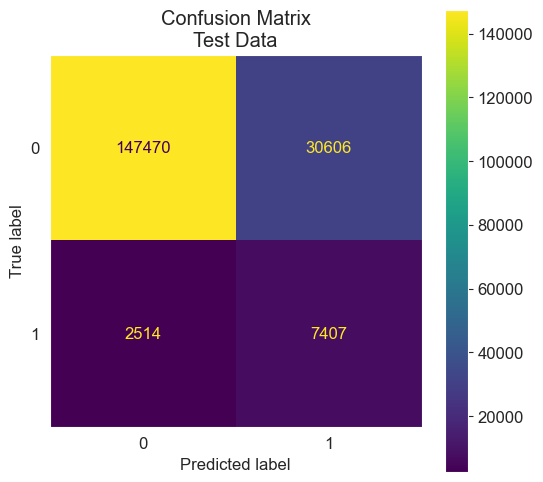

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.83      0.90    178076
           1       0.19      0.75      0.31      9921

    accuracy                           0.82    187997
   macro avg       0.59      0.79      0.60    187997
weighted avg       0.94      0.82      0.87    187997

Recall Score:
Train: 0.756
Test: 0.747 
False Positive Rate:
Train: 0.172
Test: 0.172 
Accuracy Score:
Train: 0.792
Test: 0.824 
Precision Score:
Train: 0.815
Test: 0.195 
F1 Score:
Train: 0.784
Test: 0.309 
AUC Score:
Train: 0.874
Test: 0.870 


In [888]:
###############
# MODEL FITTING #
###############

# Upsampled Data
rf_upsampled_updated = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42)
rf_upsampled_updated.fit(X_train_scaled_upsampled_updated, y_train_upsampled_updated)

##################
# MODEL EVALUATION #
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_upsampled_updated, 
    X_test_scaled_updated,  
    y_train_upsampled_updated, 
    y_test_updated, 
    rf_upsampled_updated
)

In [733]:
# Store the metrics in the DataFrame
recall_new_model.loc['Random Forest', :] = [
    recall_score(y_train_upsampled, y_pred_train).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_new_model.loc['Decision Tree', :] = [
    false_positive_rate(y_train_upsampled, y_pred_train).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---

- XGBoost with downsampling

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

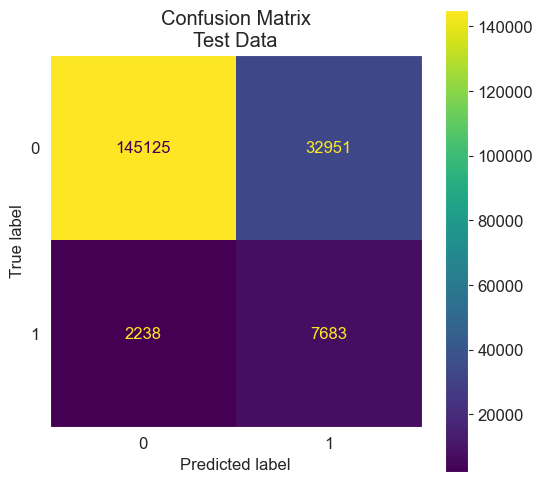

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.81      0.89    178076
           1       0.19      0.77      0.30      9921

    accuracy                           0.81    187997
   macro avg       0.59      0.79      0.60    187997
weighted avg       0.94      0.81      0.86    187997

Recall Score:
Train: 0.803
Test: 0.774 
False Positive Rate:
Train: 0.155
Test: 0.185 
Accuracy Score:
Train: 0.824
Test: 0.813 
Precision Score:
Train: 0.839
Test: 0.189 
F1 Score:
Train: 0.821
Test: 0.304 
AUC Score:
Train: 0.909
Test: 0.879 


In [889]:
###############
# MODEL FITTING #
###############

# Downsampled Data
xgb_downsampled_updated = XGBClassifier(random_state=42)
xgb_downsampled_updated.fit(X_train_scaled_downsampled_updated, y_train_downsampled_updated)

##################
# MODEL EVALUATION #
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_downsampled_updated, 
    X_test_scaled_updated,  
    y_train_downsampled_updated, 
    y_test_updated,  
    xgb_downsampled_updated
)

In [735]:
# Store the metrics in the DataFrame
recall_new_model.loc['XGBoost', :] = [
    recall_score(y_train_downsampled, y_pred_train).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_new_model.loc['XGBoost', :] = [
    false_positive_rate(y_train_downsampled, y_pred_train).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---

- Neural network with downsampling

In [ ]:
# Set up the neural network structure
nn_model_updated = Sequential([
    Dense(10, activation="relu"),   # Add hidden layer
    Dense(10, activation="relu"),   # Add hidden layer
    Dense(10, activation="relu"),   # Add hidden layer
    Dense(1, activation='sigmoid')  # Output layer
])


# Compile the model
nn_model_updated.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [
        'accuracy',
        keras.metrics.Recall(name='recall'),      # Monitoring recall
        keras.metrics.FalsePositives(name='fp')  # Monitoring false positives
    ]
)


# Create early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
# Fit the model
nn_model_updated.fit(
    X_train_scaled_downsampled_updated,
    y_train_downsampled_updated,
    epochs=100,
    batch_size=10,
    verbose=1,
    validation_data=(X_test_scaled_updated, y_test_updated),  # Assuming these variables also carry the _updated suffix
    callbacks=[early_stopping]  # Set up early stopping to prevent overfitting
)

Epoch 1/100
5953/5953 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.7593 - fp: 3133.7385 - loss: 0.4923 - recall: 0.7313 - val_accuracy: 0.8145 - val_fp: 32691.0000 - val_loss: 0.4059 - val_recall: 0.7799
Epoch 2/100
5953/5953 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.7969 - fp: 2864.5215 - loss: 0.4283 - recall: 0.7851 - val_accuracy: 0.7998 - val_fp: 35611.0000 - val_loss: 0.4310 - val_recall: 0.7966
Epoch 3/100
5953/5953 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.7987 - fp: 2838.6799 - loss: 0.4250 - recall: 0.7879 - val_accuracy: 0.7951 - val_fp: 36557.0000 - val_loss: 0.4391 - val_recall: 0.8014
Epoch 4/100
5953/5953 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.7965 - fp: 2854.4744 - loss: 0.4246 - recall: 0.7851 - val_accuracy: 0.8030 - val_fp: 34975.0000 - val_loss: 0.4404 - val_recall: 0.7919
Epoch 5/100
5953/5953 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8008 - fp: 2808.7712 - loss: 0.4221 - recall: 0.7904 - val_accuracy: 0.7996 - val_fp: 35629.0000 - val

1861/1861 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
5875/5875 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Confusion matrices: 


<Figure size 300x300 with 0 Axes>

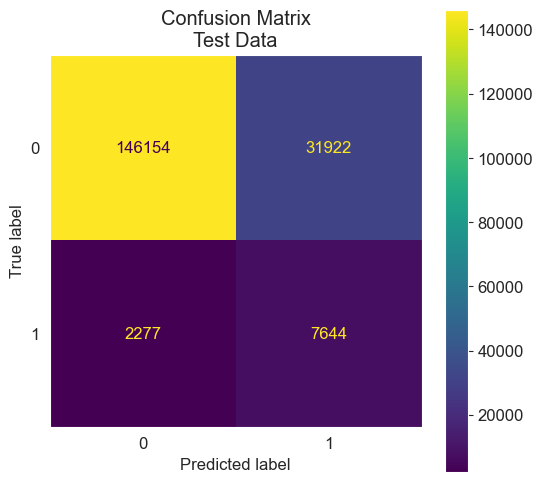

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.82      0.90    178076
           1       0.19      0.77      0.31      9921

    accuracy                           0.82    187997
   macro avg       0.59      0.80      0.60    187997
weighted avg       0.94      0.82      0.86    187997

Recall Score:
Train: 0.779
Test: 0.770 
False Positive Rate:
Train: 0.171
Test: 0.179 
Accuracy Score:
Train: 0.804
Test: 0.818 
Precision Score:
Train: 0.820
Test: 0.193 
F1 Score:
Train: 0.799
Test: 0.309 
AUC Score:
Train: 0.891
Test: 0.881 


In [ ]:
##################
# MODEL EVALUATION #
##################
(y_pred_proba_train, 
 y_pred_train, 
 y_pred_proba_test, 
 y_pred_test) = model_evaluation(
    X_train_scaled_downsampled_updated, 
    X_test_scaled_updated,  
    y_train_downsampled_updated, 
    y_test_updated,  
    nn_model_updated,  
    is_neural_network=True
)

In [737]:
# Store the metrics in the DataFrame
recall_new_model.loc['Neural Network', :] = [
    recall_score(y_train_downsampled, y_pred_train).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_new_model.loc['Neural Network', :] = [
    false_positive_rate(y_train_downsampled, y_pred_train).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---

### 12.3 Comparison And Summary  <a class="anchor" id="12c"></a>

| Model     | Feature Selection     | Number of Features | Recall | False Positive Rate | Notes              |
|--------------------|---------------------------------|--------------------|--------|----------------------|-----------------------------|
| Logistic Regression  | No  | 175    |  0.763  |0.164       | (Both model ran on upsampling data) |
| Logistic Regression  | Yes | 70    | 0.753  |0.160      | Subtle changes: recall decreased, fpr improved   |



| Model     | Feature Selection     | Number of Features | Recall | False Positive Rate | Notes              |
|--------------------|---------------------------------|--------------------|--------|----------------------|-----------------------------|
| Naive Bayes  | No  | 175    | 0.780  | 0.260       | (Both model ran on upsampling data)   |
| Naive Bayes  | Yes | 70    |0.782  | 0.238      | Both metrics improved   |



| Model     | Feature Selection     | Number of Features | Recall | False Positive Rate | Notes              |
|--------------------|---------------------------------|--------------------|--------|----------------------|-----------------------------|
| Decision Tree  | No  | 175    | 0.744  | 0.171       |   (Both model ran on upsampling data) |
| Decision Tree   | Yes | 70    | 0.740  | 0.168      | Subtle changes: recall decreased, fpr improved     |



| Model     | Feature Selection     | Number of Features | Recall | False Positive Rate | Notes              |
|--------------------|---------------------------------|--------------------|--------|----------------------|-----------------------------|
| Random Forest  | No  | 175    | 0.766  | 0.188       | (Both model ran on upsampling data)  |
| Random Forest  | Yes | 70    | 0.747  | 0.172     | Recall decreased, fpr improved   |



| Model     | Feature Selection     | Number of Features | Recall | False Positive Rate | Notes              |
|--------------------|---------------------------------|--------------------|--------|----------------------|-----------------------------|
| XGBoost  | No  | 175    | 0.781  | 0.187       | Notable Overfitting  (Both model ran on downsampling data) |
| XGBoost  | Yes | 70    | 0.774   | 0.185       | Overfitting is mitigated but still exists. Recall slightly decreased   |



| Model     | Feature Selection     | Number of Features | Recall | False Positive Rate | Notes              |
|--------------------|---------------------------------|--------------------|--------|----------------------|-----------------------------|
| Neural Network  | No  | 175    | 0.800   | 0.209      | Best performer. (Both model ran on downsampling data)   |
| Neural Network  | Yes | 70    | 0.770   | 0.179       | fpr improved with the sacrifice of recall score  |


**Summary:**
- With feature selection, the number of features after one-hot encoding has decreased by 60%, while the number of features before one-hot encoding has decreased by 49%.
- The changes in recall and false positive rate (FPR) show subtle differences in most models before and after feature selection, indicating that predictive power has not declined following the removal of certain features.
- The overfitting issue was mitigated in XGBoost; however, signs of overfitting still exist and should be addressed using grid search for hyperparameter tuning.
- Despite a drop in recall in the neural network model, the FPR improved by the same percentage. Since the current loss function is set as Binary Cross-Entropy rather than a customized function optimizing recall and FPR, the model exhibits variability in recall and FPR scores across different runs. Comparing the validation loss scores indicates that the two models perform at a similar level.

## 13 Export Model and Data <a class="anchor" id="13"></a>



Export the best performer of each classification model

In [ ]:
# Save the model using pickle
with open('../models/baseline_model/logreg_upsampled_baseline.pkl', 'wb') as logit_base:
    pickle.dump(logit_upsampled, logit_base)

with open('../models/baseline_model/naive_bayes_upsampled_baseline.pkl', 'wb') as nb_base:
    pickle.dump(nbmodel_upsampled, nb_base)

with open('../models/baseline_model/decision_tree_upsampled_baseline.pkl', 'wb') as dt_base:
    pickle.dump(dt_upsampled, dt_base)

with open('../models/baseline_model/random_forest_upsampled_baseline.pkl', 'wb') as rf_base:
    pickle.dump(rf_upsampled, rf_base)

with open('../models/baseline_model/xgboost_downsampled_baseline.pkl', 'wb') as xgb_base:
    pickle.dump(xgb_downsampled, xgb_base)


In [796]:
# Save the neural network model in HFF5 format
nn_model.save('../models/baseline_model/neural_network_baseline.keras')

---

Export the data with initial feature engineering.

In [932]:
# Export X and y before feature selection (include all features)
X.to_csv('../data/processed/X_original.csv', index=False)
y.to_csv('../data/processed/y.csv', index=False)

# Export X_selected after feature selection 
X_selected.to_csv('../data/processed/X_with_feature_selection.csv', index=False)